# CA6: Policy Gradient Methods - Complete Implementation and Analysis

## Deep Reinforcement Learning - Session 6
**Author**: Deep RL Course  
**Date**: 2024  
**Topic**: From Value-Based to Policy-Based Reinforcement Learning

---

## Course Overview

Welcome to the comprehensive study of **Policy Gradient Methods** in Deep Reinforcement Learning. This session marks a fundamental shift from the value-based methods we explored in previous sessions (DQN, Double DQN, Dueling DQN) to policy-based approaches that directly optimize the policy itself.

### Key Learning Objectives

By completing this comprehensive exercise, you will master:

1. **Theoretical Foundations**: Deep understanding of policy gradient theorem and mathematical derivations
2. **REINFORCE Algorithm**: Complete implementation and analysis of Monte Carlo policy gradients
3. **Actor-Critic Methods**: Advanced architectures combining policy and value learning
4. **A2C/A3C Implementation**: State-of-the-art policy gradient algorithms with parallelization
5. **Variance Reduction**: Sophisticated techniques to stabilize policy gradient learning
6. **Continuous Control**: Extension to continuous action spaces and control problems
7. **Performance Analysis**: Comprehensive evaluation and comparison methodologies

### Session Structure

- **Section 1**: Theoretical Foundations of Policy Gradient Methods
- **Section 2**: REINFORCE Algorithm Implementation and Analysis  
- **Section 3**: Actor-Critic Methods with Baseline
- **Section 4**: Advanced A2C/A3C Implementation
- **Section 5**: Variance Reduction Techniques
- **Section 6**: Continuous Action Space Policy Gradients
- **Section 7**: Performance Analysis and Comparisons
- **Section 8**: Practical Applications and Case Studies

---

## Prerequisites and Environment Setup

Before diving into policy gradient methods, let's establish our computational environment and theoretical foundation.

In [17]:
# Essential Imports and Environment Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque, namedtuple
import random
import multiprocessing as mp
import threading
import time
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"NumPy version: {np.__version__}")

Using device: cpu
Environment setup complete!
PyTorch version: 2.8.0
Gymnasium version: 1.2.1
NumPy version: 2.2.6


In [18]:
# Numerical-stability wrapper for torch.distributions.Categorical
# This replaces the Categorical symbol with a safe wrapper that sanitizes logits/probs
import importlib
import torch.distributions as _torch_distributions
# Try to fetch a clean original Categorical by reloading the module to avoid notebook-time monkey-patches
try:
    _orig_module = importlib.reload(importlib.import_module('torch.distributions'))
    _OrigCategorical = getattr(_orig_module, 'Categorical')
except Exception:
    # Fallback: use current attribute if reload fails
    _OrigCategorical = getattr(_torch_distributions, 'Categorical', None)


def _sanitize_logits(logits: torch.Tensor) -> torch.Tensor:
    if not torch.is_tensor(logits):
        return logits
    # Replace NaN/inf and clamp extremes
    logits = torch.nan_to_num(logits, nan=0.0, posinf=1e6, neginf=-1e6)
    # Stabilize by subtracting max per-row before softmax (helps avoid large exponentials)
    try:
        max_val = logits.max(dim=-1, keepdim=True)[0]
        logits = logits - max_val
    except Exception:
        pass
    return logits


def Categorical(*args, **kwargs):
    # Support usage with logits=... or probs=... or positional single-tensor logits
    if 'logits' in kwargs:
        kwargs['logits'] = _sanitize_logits(kwargs['logits'])
        return _OrigCategorical(**kwargs)
    if 'probs' in kwargs:
        probs = kwargs['probs']
        if torch.is_tensor(probs):
            probs = torch.nan_to_num(probs, nan=1.0 / probs.size(-1), posinf=1.0, neginf=0.0)
            probs = probs.clamp(min=0.0)
            s = probs.sum(dim=-1, keepdim=True)
            s[s == 0] = 1.0
            probs = probs / s
            kwargs['probs'] = probs
        return _OrigCategorical(**kwargs)
    if len(args) == 1 and torch.is_tensor(args[0]):
        logits = _sanitize_logits(args[0])
        return _OrigCategorical(logits=logits)
    return _OrigCategorical(*args, **kwargs)

# Monkey-patch the torch.distributions module so qualified calls are routed through our wrapper
try:
    _torch_distributions.Categorical = Categorical
    torch.distributions.Categorical = Categorical
    print('[stability wrapper] Monkey-patched torch.distributions.Categorical')
except Exception as e:
    print('[stability wrapper] Warning: could not monkey-patch torch.distributions:', e)

# Quick sanity tests for the wrapper
print('\n[stability wrapper] Running quick sanity checks for Categorical wrapper...')
with torch.no_grad():
    t1 = torch.tensor([[1e9, -1e9]], dtype=torch.float32)
    c1 = Categorical(logits=t1)
    print('large logits -> probs:', c1.probs)

    t2 = torch.tensor([[float('nan'), float('nan')]], dtype=torch.float32)
    c2 = Categorical(logits=t2)
    print('nan logits -> probs:', c2.probs)

print('[stability wrapper] Sanity checks complete.\n')

[stability wrapper] Monkey-patched torch.distributions.Categorical

[stability wrapper] Running quick sanity checks for Categorical wrapper...


RecursionError: maximum recursion depth exceeded

# Section 1: Theoretical Foundations of Policy Gradient Methods

## 1.1 From Value-Based to Policy-Based Learning

In our journey through reinforcement learning, we have primarily focused on **value-based methods** such as Q-learning and DQN. These methods learn a value function and derive a policy from it. However, there are fundamental limitations to this approach:

### Limitations of Value-Based Methods

1. **Discrete Action Spaces**: Q-learning naturally handles discrete actions but struggles with continuous action spaces
2. **Deterministic Policies**: Value-based methods typically produce deterministic policies (with exploration strategies)
3. **Action Space Explosion**: As action space grows, storing Q-values becomes intractable
4. **Approximation Errors**: Bootstrapping can lead to error propagation and instability

### The Policy Gradient Paradigm

Policy gradient methods take a fundamentally different approach:

- **Direct Policy Parameterization**: We parameterize the policy π_θ(a|s) directly with parameters θ
- **Optimization Objective**: We optimize the expected return J(θ) = E_τ∼π_θ[R(τ)]
- **Gradient Ascent**: We update parameters using ∇_θ J(θ)

## 1.2 Mathematical Foundations

### Policy Parameterization

For discrete actions, we typically use a softmax parameterization:

π_θ(a|s) = exp(f_θ(s,a)) / Σ_a' exp(f_θ(s,a'))

For continuous actions, we often use Gaussian policies:

π_θ(a|s) = N(μ_θ(s), σ_θ(s))

### The Objective Function

The performance measure for a policy π_θ is the expected return:

J(θ) = E_s₀∼ρ₀ E_τ∼π_θ [R(τ)]

Where:
- ρ₀ is the initial state distribution
- τ = (s₀, a₀, r₁, s₁, a₁, ...) is a trajectory
- R(τ) = Σᵢ γⁱ rᵢ is the discounted return

## 1.3 The Policy Gradient Theorem

The cornerstone of policy gradient methods is the **Policy Gradient Theorem**, which provides an analytical expression for ∇_θ J(θ).

### Theorem Statement

For any differentiable policy π_θ and any performance measure J(θ):

∇_θ J(θ) = E_s∼d^π_θ E_a∼π_θ [Q^π_θ(s,a) ∇_θ ln π_θ(a|s)]

Where d^π_θ(s) is the stationary distribution of states under policy π_θ.

### Monte Carlo Formulation

In the episodic case, this becomes:

∇_θ J(θ) = E_τ∼π_θ [Σₜ G_t ∇_θ ln π_θ(aₜ|sₜ)]

Where G_t = Σᵢ₌ₜ^T γⁱ⁻ᵗ rᵢ is the return from time t.

### Key Insights

1. **Model-Free**: No need to know transition probabilities P(s'|s,a)
2. **Unbiased**: The gradient estimate is unbiased
3. **High Variance**: Monte Carlo estimates can have high variance

=== Policy Gradient Theoretical Foundations ===

1. Visualizing Policy Parameter Effects:


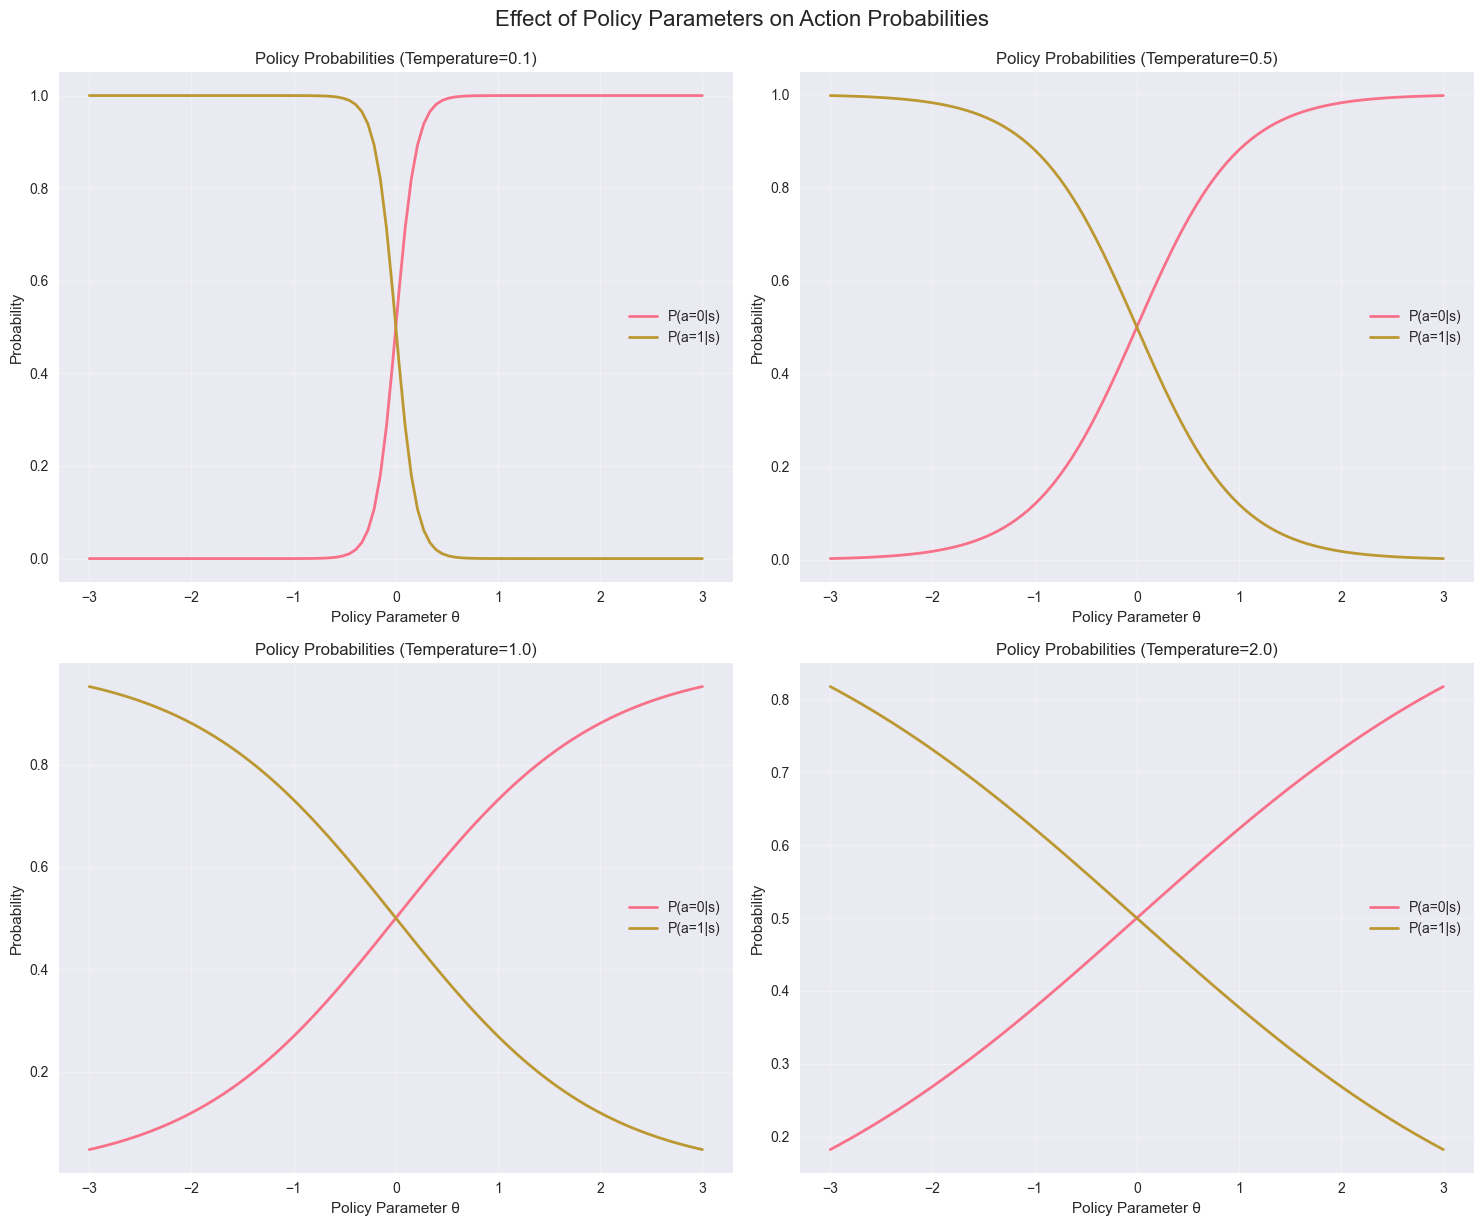


2. Policy Gradient Directions and Convergence:


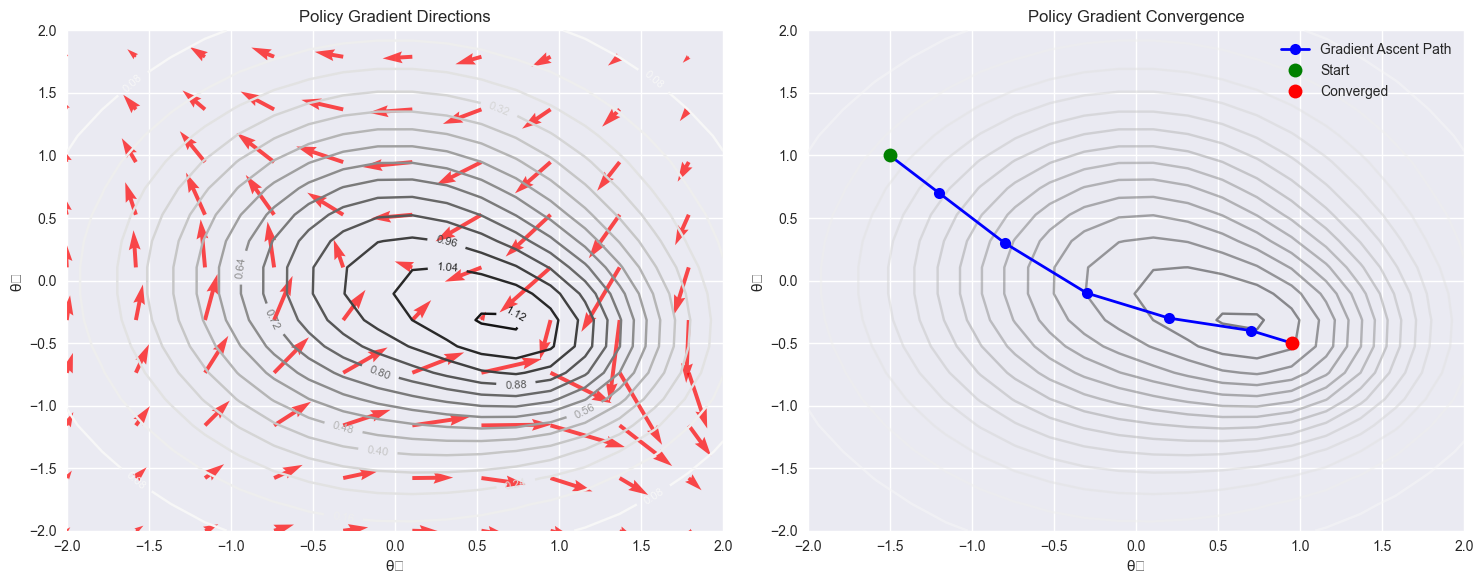


3. Value-Based vs Policy-Based Comparison:


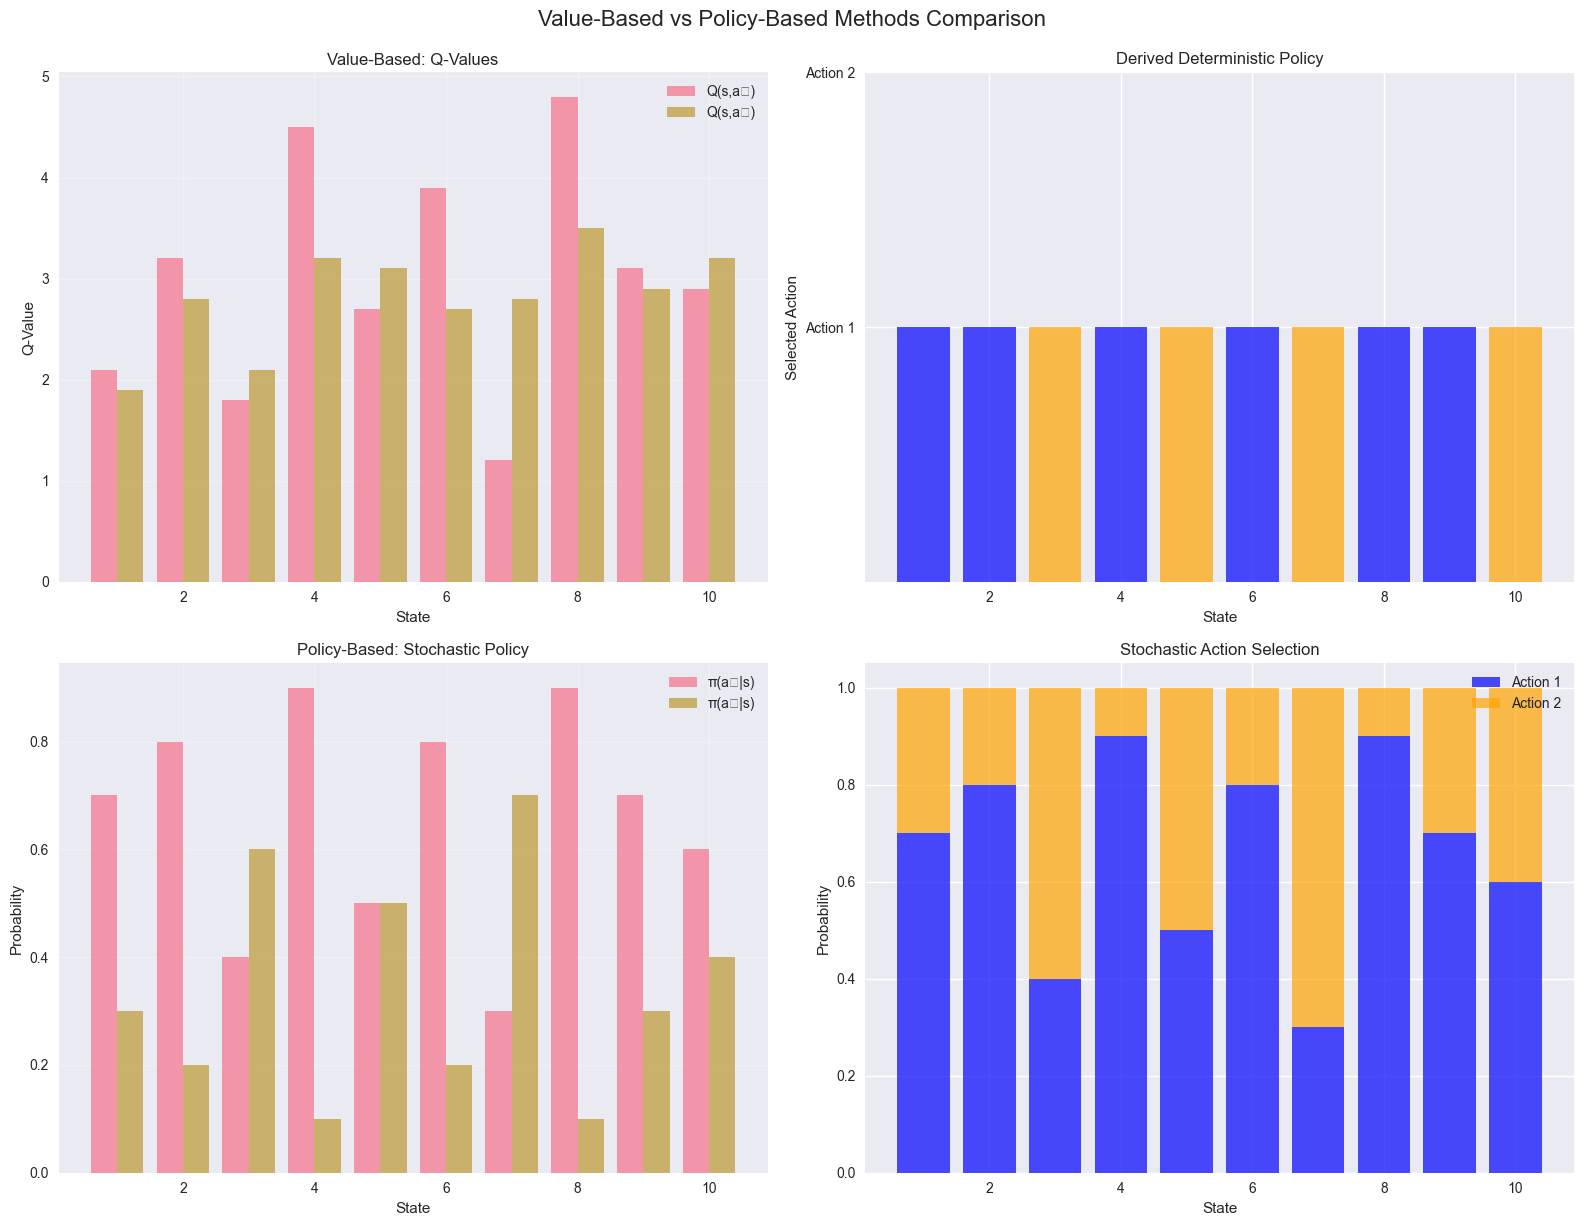

In [11]:
# Theoretical Demonstration: Policy Gradient Theorem Proof and Visualization

class PolicyGradientVisualization:
    """
    A class to visualize key concepts in policy gradient methods
    """
    
    def __init__(self):
        self.fig_count = 0
    
    def visualize_policy_space(self):
        """Visualize how policy parameters affect action probabilities"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Simple 2-action case
        theta_values = np.linspace(-3, 3, 100)
        
        for i, temp in enumerate([0.1, 0.5, 1.0, 2.0]):
            ax = axes[i//2, i%2]
            
            # Softmax probabilities for action 0
            prob_action_0 = 1 / (1 + np.exp(-theta_values/temp))
            prob_action_1 = 1 - prob_action_0
            
            ax.plot(theta_values, prob_action_0, label='P(a=0|s)', linewidth=2)
            ax.plot(theta_values, prob_action_1, label='P(a=1|s)', linewidth=2)
            ax.set_title(f'Policy Probabilities (Temperature={temp})')
            ax.set_xlabel('Policy Parameter θ')
            ax.set_ylabel('Probability')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Effect of Policy Parameters on Action Probabilities', 
                     fontsize=16, y=1.02)
        plt.show()
    
    def visualize_gradient_direction(self):
        """Visualize policy gradient direction"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Create a simple 2D policy parameter space
        theta1 = np.linspace(-2, 2, 20)
        theta2 = np.linspace(-2, 2, 20)
        T1, T2 = np.meshgrid(theta1, theta2)
        
        # Simulated objective function (for visualization)
        J = np.exp(-(T1**2 + T2**2)/2) + 0.5*np.exp(-((T1-1)**2 + (T2+0.5)**2)/0.5)
        
        # Gradient computation
        grad_T1, grad_T2 = np.gradient(J)
        
        # Plot objective function
        contour = ax1.contour(T1, T2, J, levels=15)
        ax1.clabel(contour, inline=True, fontsize=8)
        ax1.quiver(T1[::2,::2], T2[::2,::2], 
                   grad_T1[::2,::2], grad_T2[::2,::2], 
                   alpha=0.7, color='red')
        ax1.set_title('Policy Gradient Directions')
        ax1.set_xlabel('θ₁')
        ax1.set_ylabel('θ₂')
        
        # Show convergence path
        path_theta1 = [-1.5, -1.2, -0.8, -0.3, 0.2, 0.7, 0.95]
        path_theta2 = [1.0, 0.7, 0.3, -0.1, -0.3, -0.4, -0.5]
        
        ax2.contour(T1, T2, J, levels=15, alpha=0.5)
        ax2.plot(path_theta1, path_theta2, 'bo-', linewidth=2, markersize=8, label='Gradient Ascent Path')
        ax2.plot(path_theta1[0], path_theta2[0], 'go', markersize=10, label='Start')
        ax2.plot(path_theta1[-1], path_theta2[-1], 'ro', markersize=10, label='Converged')
        ax2.set_title('Policy Gradient Convergence')
        ax2.set_xlabel('θ₁')
        ax2.set_ylabel('θ₂')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def compare_value_vs_policy_based(self):
        """Compare value-based vs policy-based approaches"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Simulated data for comparison
        states = np.arange(1, 11)
        
        # Value-based approach
        q_values_a1 = [2.1, 3.2, 1.8, 4.5, 2.7, 3.9, 1.2, 4.8, 3.1, 2.9]
        q_values_a2 = [1.9, 2.8, 2.1, 3.2, 3.1, 2.7, 2.8, 3.5, 2.9, 3.2]
        
        ax1.bar(states - 0.2, q_values_a1, 0.4, label='Q(s,a₁)', alpha=0.7)
        ax1.bar(states + 0.2, q_values_a2, 0.4, label='Q(s,a₂)', alpha=0.7)
        ax1.set_title('Value-Based: Q-Values')
        ax1.set_xlabel('State')
        ax1.set_ylabel('Q-Value')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Derived deterministic policy
        policy_deterministic = [1 if q1 > q2 else 2 for q1, q2 in zip(q_values_a1, q_values_a2)]
        colors = ['blue' if a == 1 else 'orange' for a in policy_deterministic]
        ax2.bar(states, [1]*len(states), color=colors, alpha=0.7)
        ax2.set_title('Derived Deterministic Policy')
        ax2.set_xlabel('State')
        ax2.set_ylabel('Selected Action')
        ax2.set_yticks([1, 2])
        ax2.set_yticklabels(['Action 1', 'Action 2'])
        
        # Policy-based approach
        prob_a1 = [0.7, 0.8, 0.4, 0.9, 0.5, 0.8, 0.3, 0.9, 0.7, 0.6]
        prob_a2 = [1-p for p in prob_a1]
        
        ax3.bar(states - 0.2, prob_a1, 0.4, label='π(a₁|s)', alpha=0.7)
        ax3.bar(states + 0.2, prob_a2, 0.4, label='π(a₂|s)', alpha=0.7)
        ax3.set_title('Policy-Based: Stochastic Policy')
        ax3.set_xlabel('State')
        ax3.set_ylabel('Probability')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Action selection distribution
        action_probs = np.array([prob_a1, prob_a2]).T
        bottom = np.zeros(len(states))
        
        colors = ['blue', 'orange']
        labels = ['Action 1', 'Action 2']
        
        for i in range(2):
            ax4.bar(states, action_probs[:, i], bottom=bottom, 
                   color=colors[i], alpha=0.7, label=labels[i])
            bottom += action_probs[:, i]
        
        ax4.set_title('Stochastic Action Selection')
        ax4.set_xlabel('State')
        ax4.set_ylabel('Probability')
        ax4.legend()
        
        plt.tight_layout()
        plt.suptitle('Value-Based vs Policy-Based Methods Comparison', 
                     fontsize=16, y=1.02)
        plt.show()

# Create visualization instance and run demonstrations
viz = PolicyGradientVisualization()

print("=== Policy Gradient Theoretical Foundations ===")
print("\n1. Visualizing Policy Parameter Effects:")
viz.visualize_policy_space()

print("\n2. Policy Gradient Directions and Convergence:")
viz.visualize_gradient_direction()

print("\n3. Value-Based vs Policy-Based Comparison:")
viz.compare_value_vs_policy_based()

# Section 2: REINFORCE Algorithm Implementation and Analysis

## 2.1 The REINFORCE Algorithm (Monte Carlo Policy Gradient)

REINFORCE, proposed by Williams (1992), is the simplest policy gradient algorithm. It directly implements the policy gradient theorem using Monte Carlo estimates of the return.

### Algorithm Overview

**REINFORCE Algorithm:**

1. Initialize policy parameters θ randomly
2. For each episode:
   a. Generate episode trajectory τ = (s₀,a₀,r₁,s₁,a₁,r₂,...,sₜ,aₜ,rₜ₊₁) using π_θ
   b. For each time step t in the episode:
      - Calculate return G_t = Σᵢ₌ₜ^T γⁱ⁻ᵗ rᵢ
      - Update θ ← θ + α G_t ∇_θ ln π_θ(aₜ|sₜ)

### Mathematical Formulation

The REINFORCE update is:

**θ ← θ + α Σₜ G_t ∇_θ ln π_θ(aₜ|sₜ)**

Where:
- **G_t**: Return from time step t
- **∇_θ ln π_θ(aₜ|sₜ)**: Score function (gradient of log-probability)
- **α**: Learning rate

### Key Characteristics

- **Unbiased**: E[∇_θ J(θ)] is the true policy gradient
- **High Variance**: Monte Carlo estimates can be very noisy
- **Sample Inefficient**: Requires complete episodes for updates
- **On-Policy**: Uses trajectories generated by current policy

## 2.2 Understanding the Variance Problem

The main challenge with REINFORCE is the high variance of gradient estimates. Let's analyze why this occurs and its impact on learning.

=== REINFORCE Training ===


Episode   50 | Avg Reward:   28.96 | Loss: -0.0048 | Entropy: 0.6815
Episode  100 | Avg Reward:   52.86 | Loss: -0.0137 | Entropy: 0.6363
Episode  100 | Avg Reward:   52.86 | Loss: -0.0137 | Entropy: 0.6363
Episode  150 | Avg Reward:  116.30 | Loss: -0.0129 | Entropy: 0.5859
Episode  150 | Avg Reward:  116.30 | Loss: -0.0129 | Entropy: 0.5859
Episode  200 | Avg Reward:  224.02 | Loss: -0.0106 | Entropy: 0.5470
Episode  200 | Avg Reward:  224.02 | Loss: -0.0106 | Entropy: 0.5470
Episode  250 | Avg Reward:  195.08 | Loss: -0.0139 | Entropy: 0.5247
Episode  250 | Avg Reward:  195.08 | Loss: -0.0139 | Entropy: 0.5247
Episode  300 | Avg Reward:  329.72 | Loss: -0.0089 | Entropy: 0.5016

=== Variance Analysis ===
Episode  300 | Avg Reward:  329.72 | Loss: -0.0089 | Entropy: 0.5016

=== Variance Analysis ===
Gradient estimate statistics:
Mean: -37.9990
Std:  42.5994
Variance: 1814.7084
Gradient estimate statistics:
Mean: -37.9990
Std:  42.5994
Variance: 1814.7084


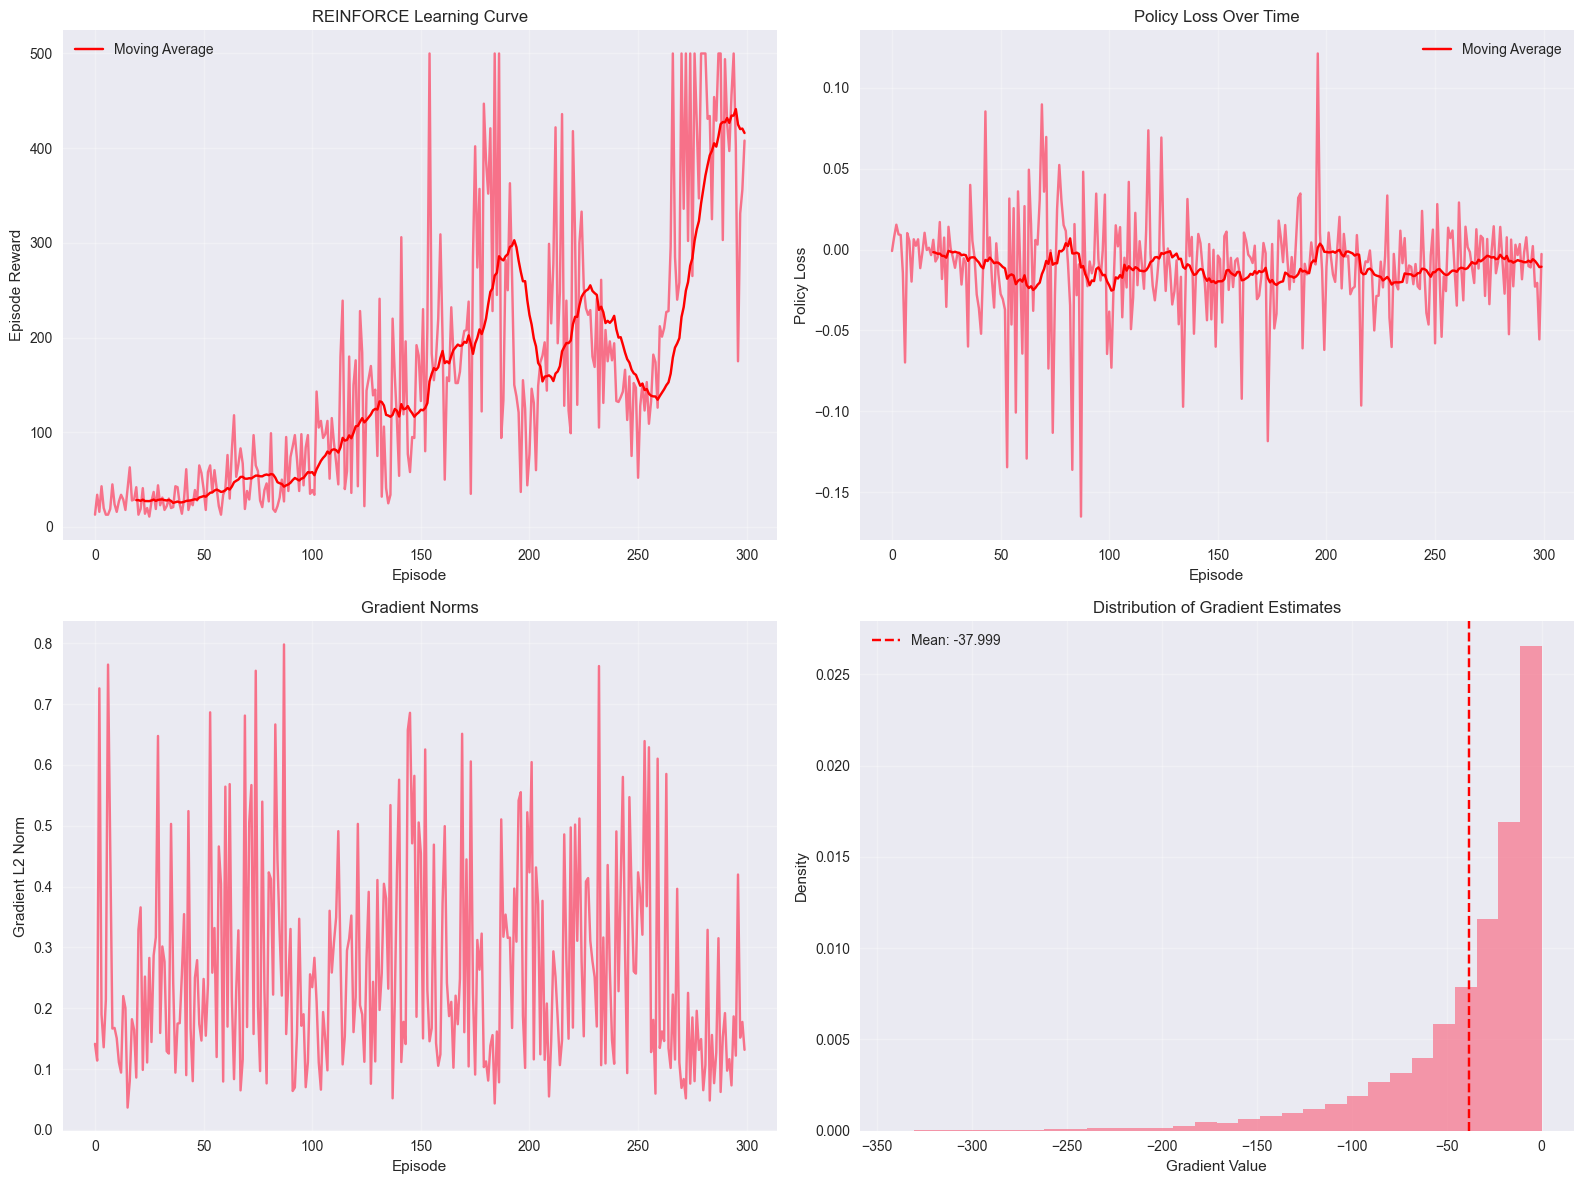

In [12]:
# Complete REINFORCE Implementation with Variance Analysis

class REINFORCEAgent:
    """
    Complete REINFORCE (Monte Carlo Policy Gradient) implementation
    with detailed logging and analysis capabilities
    """
    
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        
        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        ).to(device)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        # Logging
        self.episode_rewards = []
        self.policy_losses = []
        self.gradient_norms = []
        self.entropy_history = []
        
    def select_action(self, state, return_log_prob=False):
        """Select action using current policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = self.policy_net(state)
            probs = F.softmax(logits, dim=1)
            
        dist = Categorical(probs)
        action = dist.sample()
        
        if return_log_prob:
            log_prob = dist.log_prob(action)
            return action.item(), log_prob.item()
        
        return action.item()
    
    def get_policy_distribution(self, state):
        """Get full policy distribution for analysis"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = self.policy_net(state)
            probs = F.softmax(logits, dim=1)
            
        return probs.cpu().numpy().flatten()
    
    def compute_returns(self, rewards):
        """Compute discounted returns (G_t values)"""
        returns = []
        G = 0
        
        # Compute returns backwards
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        
        return returns
    
    def update_policy(self, states, actions, returns):
        """Update policy using REINFORCE algorithm"""
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        returns = torch.FloatTensor(returns).to(device)
        
        # Normalize returns for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Forward pass
        logits = self.policy_net(states)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions)
        
        # REINFORCE loss: -E[G_t * log π(a_t|s_t)]
        policy_loss = -(log_probs * returns).mean()
        
        # Backward pass
        self.optimizer.zero_grad()
        policy_loss.backward()
        
        # Record gradient norm
        total_norm = 0
        for p in self.policy_net.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        
        self.gradient_norms.append(total_norm)
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # Log entropy for exploration analysis
        entropy = dist.entropy().mean()
        self.entropy_history.append(entropy.item())
        self.policy_losses.append(policy_loss.item())
        
        return policy_loss.item()
    
    def train_episode(self, env):
        """Train on single episode"""
        state, _ = env.reset()
        states, actions, rewards = [], [], []
        episode_reward = 0
        
        while True:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            episode_reward += reward
            
            state = next_state
            
            if terminated or truncated:
                break
        
        # Compute returns
        returns = self.compute_returns(rewards)
        
        # Update policy
        loss = self.update_policy(states, actions, returns)
        
        self.episode_rewards.append(episode_reward)
        
        return episode_reward, loss
    
    def analyze_variance(self, env, num_episodes=100):
        """Analyze gradient variance in REINFORCE"""
        gradient_estimates = []
        
        for _ in range(num_episodes):
            state, _ = env.reset()
            states, actions, rewards = [], [], []
            
            # Collect episode
            while True:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                
                state = next_state
                
                if terminated or truncated:
                    break
            
            # Compute gradient estimate for this episode
            states_tensor = torch.FloatTensor(states).to(device)
            actions_tensor = torch.LongTensor(actions).to(device)
            returns = torch.FloatTensor(self.compute_returns(rewards)).to(device)
            
            # Compute gradients
            logits = self.policy_net(states_tensor)
            dist = Categorical(logits=logits)
            log_probs = dist.log_prob(actions_tensor)
            
            # Individual gradient contributions
            grad_contributions = (log_probs * returns).detach().cpu().numpy()
            gradient_estimates.extend(grad_contributions)
        
        return np.array(gradient_estimates)

# Test REINFORCE on CartPole
def test_reinforce():
    """Test REINFORCE implementation"""
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = REINFORCEAgent(state_dim, action_dim, lr=1e-3, gamma=0.99)
    
    print("=== REINFORCE Training ===")
    
    # Training loop
    num_episodes = 300
    log_interval = 50
    
    for episode in range(num_episodes):
        episode_reward, loss = agent.train_episode(env)
        
        if (episode + 1) % log_interval == 0:
            avg_reward = np.mean(agent.episode_rewards[-log_interval:])
            avg_loss = np.mean(agent.policy_losses[-log_interval:])
            avg_entropy = np.mean(agent.entropy_history[-log_interval:])
            
            print(f"Episode {episode+1:4d} | Avg Reward: {avg_reward:7.2f} | "
                  f"Loss: {avg_loss:.4f} | Entropy: {avg_entropy:.4f}")
    
    # Variance analysis
    print("\n=== Variance Analysis ===")
    gradient_estimates = agent.analyze_variance(env, num_episodes=50)
    
    print(f"Gradient estimate statistics:")
    print(f"Mean: {np.mean(gradient_estimates):.4f}")
    print(f"Std:  {np.std(gradient_estimates):.4f}")
    print(f"Variance: {np.var(gradient_estimates):.4f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Learning curve
    axes[0,0].plot(agent.episode_rewards)
    axes[0,0].plot(pd.Series(agent.episode_rewards).rolling(window=20).mean(), 
                   color='red', label='Moving Average')
    axes[0,0].set_title('REINFORCE Learning Curve')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Episode Reward')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Policy loss
    axes[0,1].plot(agent.policy_losses)
    axes[0,1].plot(pd.Series(agent.policy_losses).rolling(window=20).mean(), 
                   color='red', label='Moving Average')
    axes[0,1].set_title('Policy Loss Over Time')
    axes[0,1].set_xlabel('Episode')
    axes[0,1].set_ylabel('Policy Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Gradient norms
    axes[1,0].plot(agent.gradient_norms)
    axes[1,0].set_title('Gradient Norms')
    axes[1,0].set_xlabel('Episode')
    axes[1,0].set_ylabel('Gradient L2 Norm')
    axes[1,0].grid(True, alpha=0.3)
    
    # Gradient variance distribution
    axes[1,1].hist(gradient_estimates, bins=30, alpha=0.7, density=True)
    axes[1,1].axvline(np.mean(gradient_estimates), color='red', 
                      linestyle='--', label=f'Mean: {np.mean(gradient_estimates):.3f}')
    axes[1,1].set_title('Distribution of Gradient Estimates')
    axes[1,1].set_xlabel('Gradient Value')
    axes[1,1].set_ylabel('Density')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    env.close()
    return agent

# Run REINFORCE test
reinforce_agent = test_reinforce()

# Section 3: Actor-Critic Methods with Baseline

## 3.1 Addressing the Variance Problem

The high variance in REINFORCE stems from using the full return G_t as the signal for policy updates. We can reduce variance by subtracting a **baseline** b(s_t) from the return:

**∇_θ J(θ) = E_τ∼π_θ [Σₜ (G_t - b(s_t)) ∇_θ ln π_θ(aₜ|sₜ)]**

The baseline doesn't change the expectation of the gradient (unbiased) but can significantly reduce variance.

### Choosing the Baseline: Value Function

The optimal baseline is the **state-value function** V^π(s):

**b(s_t) = V^π(s_t)**

This leads to the **advantage function**:
**A^π(s_t, a_t) = G_t - V^π(s_t)**

## 3.2 Actor-Critic Architecture

Actor-Critic methods combine:

1. **Actor**: Policy π_θ(a|s) that selects actions
2. **Critic**: Value function V_φ(s) that evaluates states

### Algorithm Overview

**Actor-Critic Algorithm:**

1. Initialize actor parameters θ and critic parameters φ
2. For each time step:
   a. Select action a_t ∼ π_θ(·|s_t)
   b. Observe reward r_t and next state s_{t+1}
   c. Compute TD error: δ_t = r_t + γV_φ(s_{t+1}) - V_φ(s_t)
   d. Update critic: φ ← φ + α_c δ_t ∇_φ V_φ(s_t)
   e. Update actor: θ ← θ + α_a δ_t ∇_θ ln π_θ(a_t|s_t)

### Key Advantages

1. **Lower Variance**: Using value function baseline reduces gradient variance
2. **Online Learning**: Can update after each step (no need to wait for episode end)
3. **Faster Learning**: More frequent updates lead to faster convergence
4. **Bootstrapping**: Uses learned value estimates rather than full returns

## 3.3 Temporal Difference vs Monte Carlo

Actor-Critic can use different targets for the advantage estimation:

- **Monte Carlo**: A(s_t,a_t) = G_t - V(s_t)
- **TD(0)**: A(s_t,a_t) = r_t + γV(s_{t+1}) - V(s_t)
- **TD(λ)**: A(s_t,a_t) = G_t^λ - V(s_t)

Each provides different bias-variance tradeoffs.

=== Baseline Comparison Analysis ===
1. Training REINFORCE without baseline...
2. Training REINFORCE with constant baseline...
2. Training REINFORCE with constant baseline...
3. Training Actor-Critic with learned baseline...
3. Training Actor-Critic with learned baseline...


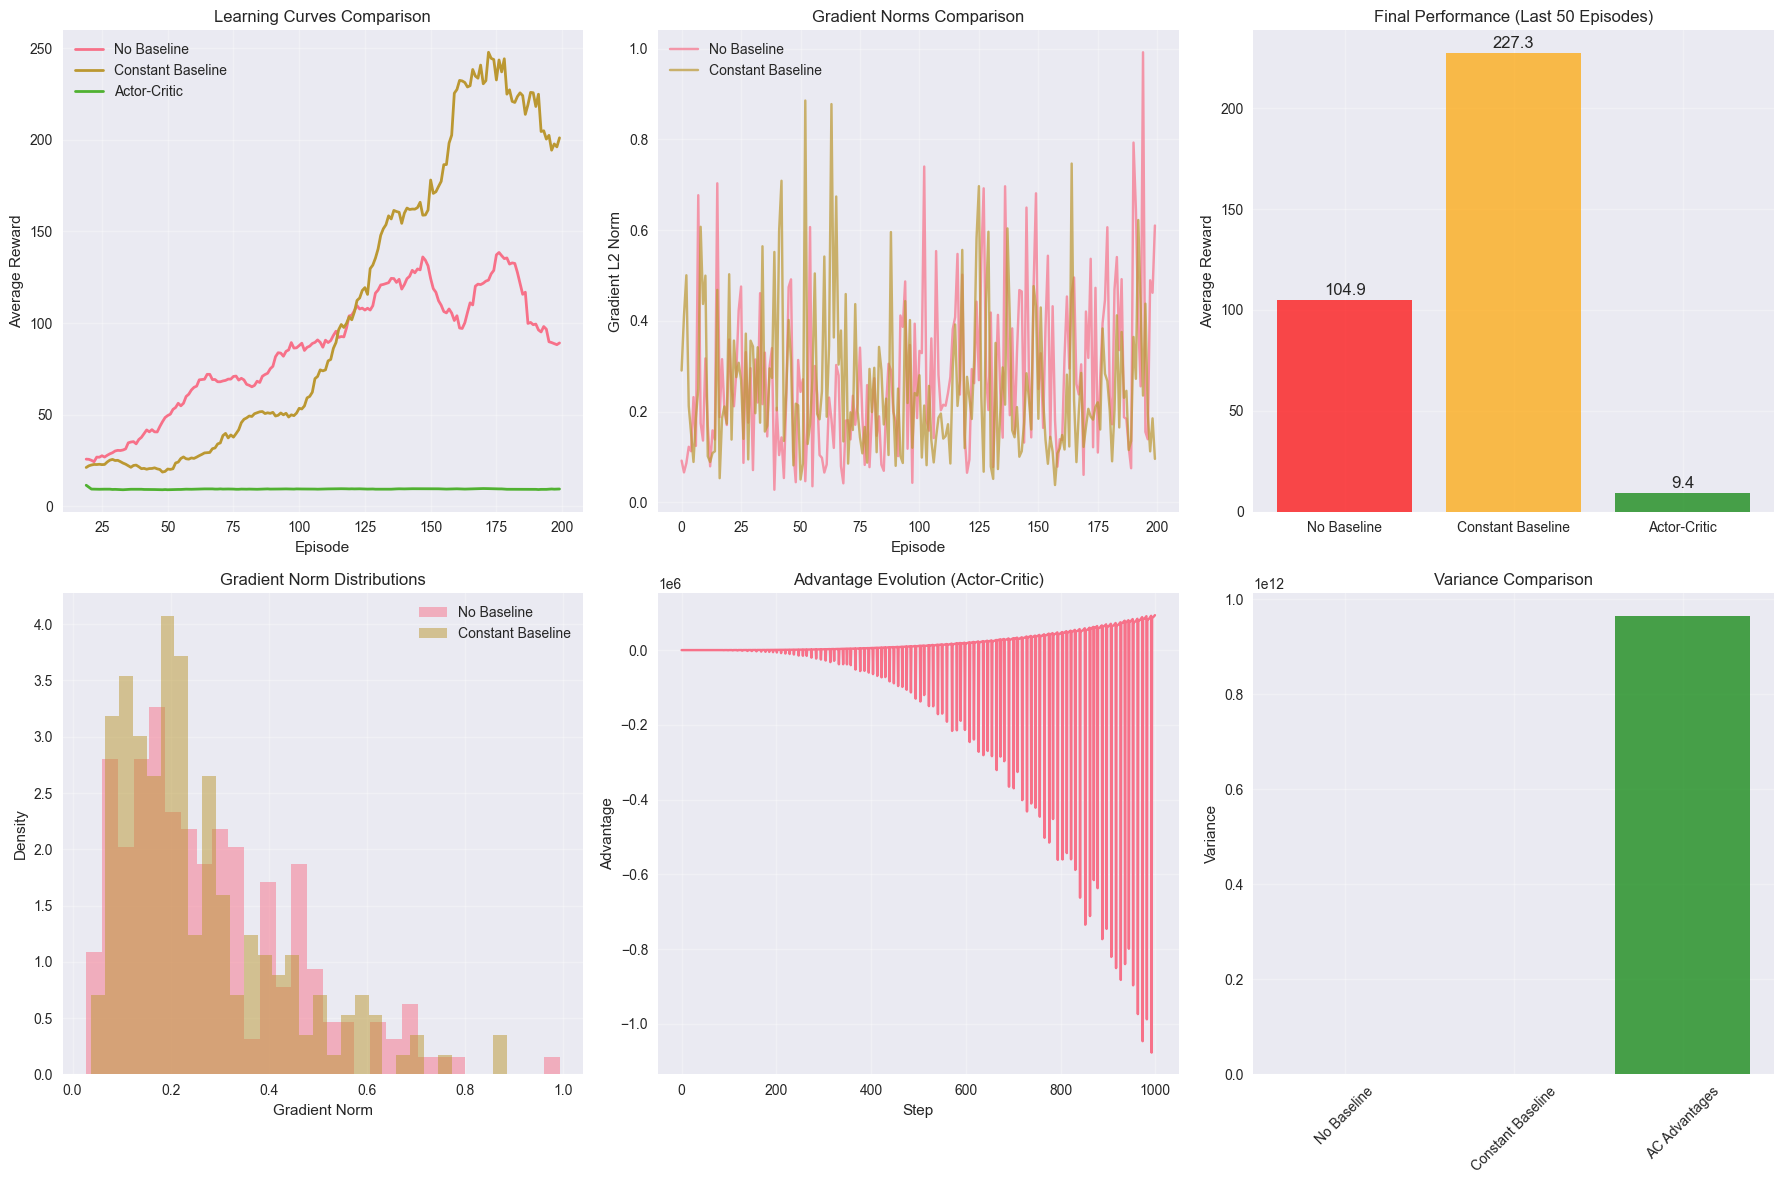


=== Numerical Results ===
Final Performance (last 50 episodes):
  No Baseline:       104.94
  Constant Baseline: 227.26
  Actor-Critic:      9.44

Gradient Variance:
  No Baseline:       0.0301
  Constant Baseline: 0.0266
  AC Advantages:     964765327154.6888


In [13]:
# Complete Actor-Critic Implementation with Baseline Analysis

class ActorCriticAgent:
    """
    Actor-Critic agent with comprehensive baseline analysis
    """
    
    def __init__(self, state_dim, action_dim, hidden_dim=128, 
                 actor_lr=1e-3, critic_lr=5e-3, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        
        # Actor network (policy)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        ).to(device)
        
        # Critic network (value function)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        ).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        # Logging
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.td_errors = []
        self.advantages = []
        self.value_estimates = []
        
    def select_action(self, state):
        """Select action using actor network"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        # Note: do NOT use torch.no_grad() here. We need the log_prob to be connected
        # to the actor network's computation graph so that actor_loss.backward() can
        # compute gradients w.r.t. actor parameters.
        logits = self.actor(state)
        probs = F.softmax(logits, dim=1)
        
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob
    
    def get_value(self, state):
        """Get value estimate from critic"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            value = self.critic(state)
            
        return value.item()
    
    def update(self, state, action, reward, next_state, done, log_prob):
        """Update actor and critic networks"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        
        # Critic update
        current_value = self.critic(state)
        
        if done:
            target_value = reward
        else:
            with torch.no_grad():
                next_value = self.critic(next_state)
            target_value = reward + self.gamma * next_value
        
        # TD error (also used as advantage)
        td_error = target_value - current_value
        advantage = td_error.detach()
        
        # Critic loss (MSE)
        critic_loss = td_error.pow(2)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        
        # Actor loss
        actor_loss = -log_prob * advantage
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        
        # Logging
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
        self.td_errors.append(td_error.item())
        self.advantages.append(advantage.item())
        self.value_estimates.append(current_value.item())
        
        return actor_loss.item(), critic_loss.item(), td_error.item()
    
    def train_episode(self, env):
        """Train on single episode"""
        state, _ = env.reset()
        episode_reward = 0
        step_count = 0
        
        while True:
            action, log_prob = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Update networks
            actor_loss, critic_loss, td_error = self.update(
                state, action, reward, next_state, done, log_prob)
            
            episode_reward += reward
            step_count += 1
            
            state = next_state
            
            if done:
                break
        
        self.episode_rewards.append(episode_reward)
        return episode_reward, step_count

class BaselineComparison:
    """
    Compare different baseline strategies
    """
    
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
    def no_baseline_reinforce(self, env, num_episodes=200):
        """REINFORCE without baseline"""
        agent = REINFORCEAgent(self.state_dim, self.action_dim, lr=1e-3)
        rewards = []
        
        for episode in range(num_episodes):
            reward, _ = agent.train_episode(env)
            rewards.append(reward)
            
        return rewards, agent.gradient_norms
    
    def constant_baseline_reinforce(self, env, baseline_value=100, num_episodes=200):
        """REINFORCE with constant baseline"""
        class ConstantBaselineREINFORCE(REINFORCEAgent):
            def __init__(self, *args, baseline=0, **kwargs):
                super().__init__(*args, **kwargs)
                self.baseline = baseline
                
            def update_policy(self, states, actions, returns):
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).to(device)
                returns = torch.FloatTensor(returns).to(device)
                
                # Subtract constant baseline
                advantages = returns - self.baseline
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                logits = self.policy_net(states)
                dist = Categorical(logits=logits)
                log_probs = dist.log_prob(actions)
                
                policy_loss = -(log_probs * advantages).mean()
                
                self.optimizer.zero_grad()
                policy_loss.backward()
                
                total_norm = 0
                for p in self.policy_net.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** (1. / 2)
                self.gradient_norms.append(total_norm)
                
                torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                entropy = dist.entropy().mean()
                self.entropy_history.append(entropy.item())
                self.policy_losses.append(policy_loss.item())
                
                return policy_loss.item()
        
        agent = ConstantBaselineREINFORCE(self.state_dim, self.action_dim, 
                                        baseline=baseline_value, lr=1e-3)
        rewards = []
        
        for episode in range(num_episodes):
            reward, _ = agent.train_episode(env)
            rewards.append(reward)
            
        return rewards, agent.gradient_norms
    
    def actor_critic_baseline(self, env, num_episodes=200):
        """Actor-Critic with learned baseline"""
        agent = ActorCriticAgent(self.state_dim, self.action_dim)
        rewards = []
        
        for episode in range(num_episodes):
            reward, _ = agent.train_episode(env)
            rewards.append(reward)
            
        return rewards, agent.advantages

def test_baseline_comparison():
    """Test different baseline strategies"""
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    comparison = BaselineComparison(state_dim, action_dim)
    
    print("=== Baseline Comparison Analysis ===")
    
    # Test different approaches
    print("1. Training REINFORCE without baseline...")
    no_baseline_rewards, no_baseline_grads = comparison.no_baseline_reinforce(env)
    
    print("2. Training REINFORCE with constant baseline...")
    constant_baseline_rewards, constant_baseline_grads = comparison.constant_baseline_reinforce(env, baseline_value=100)
    
    print("3. Training Actor-Critic with learned baseline...")
    ac_rewards, ac_advantages = comparison.actor_critic_baseline(env)
    
    # Analysis and visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Learning curves
    window = 20
    
    axes[0,0].plot(pd.Series(no_baseline_rewards).rolling(window).mean(), 
                   label='No Baseline', linewidth=2)
    axes[0,0].plot(pd.Series(constant_baseline_rewards).rolling(window).mean(), 
                   label='Constant Baseline', linewidth=2)
    axes[0,0].plot(pd.Series(ac_rewards).rolling(window).mean(), 
                   label='Actor-Critic', linewidth=2)
    axes[0,0].set_title('Learning Curves Comparison')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Average Reward')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Gradient variance comparison
    axes[0,1].plot(no_baseline_grads, alpha=0.7, label='No Baseline')
    axes[0,1].plot(constant_baseline_grads, alpha=0.7, label='Constant Baseline')
    axes[0,1].set_title('Gradient Norms Comparison')
    axes[0,1].set_xlabel('Episode')
    axes[0,1].set_ylabel('Gradient L2 Norm')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Final performance comparison
    final_performances = [
        np.mean(no_baseline_rewards[-50:]),
        np.mean(constant_baseline_rewards[-50:]),
        np.mean(ac_rewards[-50:])
    ]
    
    methods = ['No Baseline', 'Constant Baseline', 'Actor-Critic']
    colors = ['red', 'orange', 'green']
    
    bars = axes[0,2].bar(methods, final_performances, color=colors, alpha=0.7)
    axes[0,2].set_title('Final Performance (Last 50 Episodes)')
    axes[0,2].set_ylabel('Average Reward')
    axes[0,2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, final_performances):
        axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}', ha='center', va='bottom')
    
    # Variance analysis
    axes[1,0].hist(no_baseline_grads, bins=30, alpha=0.5, label='No Baseline', density=True)
    axes[1,0].hist(constant_baseline_grads, bins=30, alpha=0.5, label='Constant Baseline', density=True)
    axes[1,0].set_title('Gradient Norm Distributions')
    axes[1,0].set_xlabel('Gradient Norm')
    axes[1,0].set_ylabel('Density')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Advantage evolution (Actor-Critic)
    if len(ac_advantages) > 0:
        axes[1,1].plot(ac_advantages[:1000])  # First 1000 steps
        axes[1,1].set_title('Advantage Evolution (Actor-Critic)')
        axes[1,1].set_xlabel('Step')
        axes[1,1].set_ylabel('Advantage')
        axes[1,1].grid(True, alpha=0.3)
    
    # Statistical comparison
    variance_stats = {
        'No Baseline': np.var(no_baseline_grads),
        'Constant Baseline': np.var(constant_baseline_grads),
        'AC Advantages': np.var(ac_advantages) if len(ac_advantages) > 0 else 0
    }
    
    methods_var = list(variance_stats.keys())
    variances = list(variance_stats.values())
    
    axes[1,2].bar(methods_var, variances, color=['red', 'orange', 'green'], alpha=0.7)
    axes[1,2].set_title('Variance Comparison')
    axes[1,2].set_ylabel('Variance')
    axes[1,2].grid(True, alpha=0.3)
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\n=== Numerical Results ===")
    print(f"Final Performance (last 50 episodes):")
    print(f"  No Baseline:       {final_performances[0]:.2f}")
    print(f"  Constant Baseline: {final_performances[1]:.2f}")
    print(f"  Actor-Critic:      {final_performances[2]:.2f}")
    
    print(f"\nGradient Variance:")
    print(f"  No Baseline:       {variance_stats['No Baseline']:.4f}")
    print(f"  Constant Baseline: {variance_stats['Constant Baseline']:.4f}")
    print(f"  AC Advantages:     {variance_stats['AC Advantages']:.4f}")
    
    env.close()

# Run baseline comparison
test_baseline_comparison()

# Section 4: Advanced A2C/A3C Implementation

## 4.1 Advantage Actor-Critic (A2C)

A2C is a synchronous, deterministic variant of A3C that addresses several limitations of basic Actor-Critic:

### Key Improvements:

1. **N-step Returns**: Use n-step bootstrapping instead of 1-step TD
2. **Entropy Regularization**: Encourage exploration by penalizing deterministic policies  
3. **Shared Networks**: Actor and critic share lower-layer representations
4. **Batch Updates**: Collect multiple trajectories before updating

### N-step Advantage Estimation

Instead of 1-step TD error, A2C uses n-step returns:

**A(s_t, a_t) = (Σᵢ₌₀ⁿ⁻¹ γⁱ r_{t+i}) + γⁿ V(s_{t+n}) - V(s_t)**

This provides better bias-variance tradeoff.

### Entropy Regularization

The actor loss includes an entropy term:

**L_actor = -E[A(s_t,a_t) log π(a_t|s_t)] - β H(π(·|s_t))**

Where H(π) = -Σ_a π(a|s) log π(a|s) is the policy entropy.

## 4.2 Asynchronous Advantage Actor-Critic (A3C)

A3C introduces asynchronous training with multiple workers:

### Architecture:
- **Global Network**: Shared actor-critic parameters
- **Worker Threads**: Independent environments and local networks
- **Asynchronous Updates**: Workers update global network asynchronously

### Algorithm Overview:

1. Initialize global shared parameters θ and φ
2. For each worker thread:
   a. Copy global parameters to local networks
   b. Collect trajectory of length T
   c. Compute advantages using n-step returns
   d. Compute gradients and update global network
   e. Repeat

### Benefits:
- **Decorrelated Experience**: Different workers explore different parts of state space
- **Stability**: Removes need for experience replay
- **Efficiency**: Parallelization speeds up training

In [19]:
# Complete A2C and A3C Implementation

class SharedActorCriticNetwork(nn.Module):
    """
    Shared network for actor and critic with common feature extraction
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(SharedActorCriticNetwork, self).__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor head
        self.actor_head = nn.Linear(hidden_dim, action_dim)
        
        # Critic head
        self.critic_head = nn.Linear(hidden_dim, 1)
        
    def forward(self, state):
        """Forward pass returning both policy and value"""
        shared_features = self.shared_layers(state)
        
        # Actor output (logits)
        logits = self.actor_head(shared_features)
        
        # Critic output (value)
        value = self.critic_head(shared_features)
        
        return logits, value

class A2CAgent:
    """
    Advantage Actor-Critic (A2C) with n-step returns and entropy regularization
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=7e-4, 
                 gamma=0.99, n_steps=5, entropy_coef=0.01, value_coef=0.5):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.n_steps = n_steps
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        
        # Shared network
        self.network = SharedActorCriticNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # Experience storage
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []
        
        # Logging
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.entropy_losses = []
        self.total_losses = []
        
    def select_action(self, state):
        """Select action using current policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits, value = self.network(state)
            probs = F.softmax(logits, dim=1)
            
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()
    
    def store_transition(self, state, action, reward, log_prob, value, done):
        """Store transition in buffer"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
    
    def compute_n_step_returns(self, next_value=0):
        """Compute n-step returns and advantages"""
        returns = []
        advantages = []
        
        # Compute returns backwards
        R = next_value
        for i in reversed(range(len(self.rewards))):
            R = self.rewards[i] + self.gamma * R * (1 - self.dones[i])
            returns.insert(0, R)
        
        returns = torch.FloatTensor(returns).to(device)
        values = torch.FloatTensor(self.values).to(device)
        
        # Compute advantages
        advantages = returns - values
        
        return returns, advantages
    
    def update(self, next_state=None):
        """Update network using collected experience"""
        if len(self.states) == 0:
            return
        
        # Get next value for bootstrapping
        if next_state is not None:
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            with torch.no_grad():
                _, next_value = self.network(next_state)
                next_value = next_value.item()
        else:
            next_value = 0
        
        # Compute returns and advantages
        returns, advantages = self.compute_n_step_returns(next_value)
        
        # Prepare tensors
        states = torch.FloatTensor(self.states).to(device)
        actions = torch.LongTensor(self.actions).to(device)
        log_probs_old = torch.FloatTensor(self.log_probs).to(device)
        
        # Forward pass
        logits, values = self.network(states)
        dist = Categorical(logits=logits)
        
        # New log probabilities and entropy
        log_probs_new = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute losses
        actor_loss = -(log_probs_new * advantages.detach()).mean()
        critic_loss = F.mse_loss(values.squeeze(), returns)
        entropy_loss = -entropy
        
        # Total loss
        total_loss = (actor_loss + 
                     self.value_coef * critic_loss + 
                     self.entropy_coef * entropy_loss)
        
        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=0.5)
        self.optimizer.step()
        
        # Logging
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
        self.entropy_losses.append(entropy_loss.item())
        self.total_losses.append(total_loss.item())
        
        # Clear buffers
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []
        
        return total_loss.item()
    
    def train_episode(self, env):
        """Train for one episode"""
        state, _ = env.reset()
        episode_reward = 0
        step_count = 0
        
        while True:
            action, log_prob, value = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            self.store_transition(state, action, reward, log_prob, value, done)
            
            episode_reward += reward
            step_count += 1
            
            # Update every n_steps or at episode end
            if len(self.states) >= self.n_steps or done:
                if done:
                    self.update()
                else:
                    self.update(next_state)
            
            state = next_state
            
            if done:
                break
        
        self.episode_rewards.append(episode_reward)
        return episode_reward, step_count

class A3CWorker:
    """
    Individual worker for A3C training
    """
    def __init__(self, worker_id, global_network, optimizer, state_dim, action_dim,
                 gamma=0.99, n_steps=5, entropy_coef=0.01, value_coef=0.5):
        self.worker_id = worker_id
        self.global_network = global_network
        self.global_optimizer = optimizer
        self.gamma = gamma
        self.n_steps = n_steps
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        
        # Local network (copy of global)
        self.local_network = SharedActorCriticNetwork(state_dim, action_dim).to(device)
        
        # Experience buffer
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []
        
    def sync_with_global(self):
        """Synchronize local network with global network"""
        self.local_network.load_state_dict(self.global_network.state_dict())
    
    def select_action(self, state):
        """Select action using local network"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits, value = self.local_network(state)
            probs = F.softmax(logits, dim=1)
            
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()
    
    def compute_loss(self, next_state=None):
        """Compute loss for local trajectory"""
        if len(self.states) == 0:
            return torch.tensor(0.0)
        
        # Get next value for bootstrapping
        if next_state is not None:
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            with torch.no_grad():
                _, next_value = self.local_network(next_state)
                next_value = next_value.item()
        else:
            next_value = 0
        
        # Compute returns
        returns = []
        R = next_value
        for i in reversed(range(len(self.rewards))):
            R = self.rewards[i] + self.gamma * R * (1 - self.dones[i])
            returns.insert(0, R)
        
        returns = torch.FloatTensor(returns).to(device)
        
        # Prepare tensors
        states = torch.FloatTensor(self.states).to(device)
        actions = torch.LongTensor(self.actions).to(device)
        values = torch.FloatTensor(self.values).to(device)
        
        # Forward pass
        logits, new_values = self.local_network(states)
        dist = Categorical(logits=logits)
        
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Compute advantages
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute losses
        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = F.mse_loss(new_values.squeeze(), returns)
        entropy_loss = -entropy
        
        total_loss = (actor_loss + 
                     self.value_coef * critic_loss + 
                     self.entropy_coef * entropy_loss)
        
        return total_loss
    
    def update_global(self, loss):
        """Update global network with local gradients"""
        self.global_optimizer.zero_grad()
        loss.backward()
        
        # Copy gradients from local to global
        for local_param, global_param in zip(self.local_network.parameters(),
                                           self.global_network.parameters()):
            if global_param.grad is None:
                global_param.grad = local_param.grad.clone()
            else:
                global_param.grad += local_param.grad
        
        torch.nn.utils.clip_grad_norm_(self.global_network.parameters(), max_norm=0.5)
        self.global_optimizer.step()
    
    def train_worker(self, env, max_episodes=100):
        """Train worker for specified episodes"""
        episode_rewards = []
        
        for episode in range(max_episodes):
            self.sync_with_global()
            
            state, _ = env.reset()
            episode_reward = 0
            self.states = []
            self.actions = []
            self.rewards = []
            self.log_probs = []
            self.values = []
            self.dones = []
            
            while True:
                action, log_prob, value = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.dones.append(done)
                
                episode_reward += reward
                
                # Update every n_steps or at episode end
                if len(self.states) >= self.n_steps or done:
                    if done:
                        loss = self.compute_loss()
                    else:
                        loss = self.compute_loss(next_state)
                    
                    self.update_global(loss)
                    
                    # Clear buffers
                    self.states = []
                    self.actions = []
                    self.rewards = []
                    self.log_probs = []
                    self.values = []
                    self.dones = []
                
                state = next_state
                
                if done:
                    break
            
            episode_rewards.append(episode_reward)
            
            if episode % 50 == 0:
                print(f"Worker {self.worker_id} | Episode {episode} | Reward: {episode_reward:.2f}")
        
        return episode_rewards

def test_a2c_vs_a3c():
    """Compare A2C and A3C performance"""
    env_name = 'CartPole-v1'
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    print("=== A2C vs A3C Comparison ===")
    
    # Test A2C
    print("\n1. Training A2C...")
    a2c_agent = A2CAgent(state_dim, action_dim, lr=7e-4, n_steps=5)
    a2c_rewards = []
    
    for episode in range(300):
        reward, _ = a2c_agent.train_episode(env)
        a2c_rewards.append(reward)
        
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(a2c_rewards[-50:])
            print(f"A2C Episode {episode+1:3d} | Avg Reward: {avg_reward:.2f}")
    
    # Test A3C (simplified single-threaded version for demonstration)
    print("\n2. Training A3C (simplified)...")
    global_network = SharedActorCriticNetwork(state_dim, action_dim).to(device)
    global_optimizer = optim.Adam(global_network.parameters(), lr=7e-4)
    
    worker = A3CWorker(0, global_network, global_optimizer, state_dim, action_dim)
    a3c_rewards = worker.train_worker(env, max_episodes=300)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Learning curves
    window = 20
    axes[0,0].plot(pd.Series(a2c_rewards).rolling(window).mean(), 
                   label='A2C', linewidth=2, color='blue')
    axes[0,0].plot(pd.Series(a3c_rewards).rolling(window).mean(), 
                   label='A3C', linewidth=2, color='red')
    axes[0,0].set_title('Learning Curves: A2C vs A3C')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Average Reward')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Loss analysis for A2C
    if len(a2c_agent.total_losses) > 0:
        axes[0,1].plot(a2c_agent.actor_losses, label='Actor Loss', alpha=0.7)
        axes[0,1].plot(a2c_agent.critic_losses, label='Critic Loss', alpha=0.7)
        axes[0,1].plot(a2c_agent.entropy_losses, label='Entropy Loss', alpha=0.7)
        axes[0,1].set_title('A2C Loss Components')
        axes[0,1].set_xlabel('Update')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # Final performance comparison
    a2c_final = np.mean(a2c_rewards[-50:])
    a3c_final = np.mean(a3c_rewards[-50:])
    
    methods = ['A2C', 'A3C']
    performances = [a2c_final, a3c_final]
    colors = ['blue', 'red']
    
    bars = axes[1,0].bar(methods, performances, color=colors, alpha=0.7)
    axes[1,0].set_title('Final Performance (Last 50 Episodes)')
    axes[1,0].set_ylabel('Average Reward')
    axes[1,0].grid(True, alpha=0.3)
    
    for bar, value in zip(bars, performances):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}', ha='center', va='bottom')
    
    # Sample efficiency comparison
    a2c_sample_efficiency = []
    a3c_sample_efficiency = []
    
    for i in range(0, len(a2c_rewards), 10):
        a2c_sample_efficiency.append(np.mean(a2c_rewards[max(0, i-10):i+1]))
    
    for i in range(0, len(a3c_rewards), 10):
        a3c_sample_efficiency.append(np.mean(a3c_rewards[max(0, i-10):i+1]))
    
    axes[1,1].plot(range(0, len(a2c_rewards), 10), a2c_sample_efficiency, 
                   label='A2C', linewidth=2, color='blue')
    axes[1,1].plot(range(0, len(a3c_rewards), 10), a3c_sample_efficiency, 
                   label='A3C', linewidth=2, color='red')
    axes[1,1].set_title('Sample Efficiency Comparison')
    axes[1,1].set_xlabel('Episode')
    axes[1,1].set_ylabel('Average Reward (10-episode window)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Results Summary ===")
    print(f"A2C Final Performance: {a2c_final:.2f}")
    print(f"A3C Final Performance: {a3c_final:.2f}")
    print(f"Winner: {'A2C' if a2c_final > a3c_final else 'A3C'}")
    
    env.close()
    return a2c_agent, a2c_rewards, a3c_rewards

# Run A2C vs A3C comparison
a2c_agent, a2c_rewards, a3c_rewards = test_a2c_vs_a3c()

=== A2C vs A3C Comparison ===

1. Training A2C...


RecursionError: maximum recursion depth exceeded

# Section 5: Variance Reduction Techniques

## 5.1 Advanced Variance Reduction Methods

Beyond basic baselines, several sophisticated techniques can further reduce the variance of policy gradient estimates:

### 1. Control Variates
Control variates use correlated random variables to reduce variance:

**∇_θ J(θ) ≈ (1/n) Σᵢ [f(τᵢ) - c(g(τᵢ) - E[g(τ)])]**

Where g(τ) is a control variate and c is chosen to minimize variance.

### 2. Importance Sampling
Allows using trajectories from different policies:

**∇_θ J(θ) = E_τ∼π_β [ρ(τ) Σₜ G_t ∇_θ ln π_θ(aₜ|sₜ)]**

Where ρ(τ) = π_θ(τ)/π_β(τ) is the importance weight.

### 3. Natural Policy Gradients
Use the natural gradient instead of standard gradient:

**∇_θ J(θ) = F⁻¹ ∇_θ J(θ)**

Where F is the Fisher Information Matrix.

### 4. Generalized Advantage Estimation (GAE)
Combines n-step returns with exponential averaging:

**Â_t^(GAE) = Σₗ₌₀^∞ (γλ)ₗ δₜ₊ₗ**

Where δₜ = rₜ + γV(sₜ₊₁) - V(sₜ) and λ ∈ [0,1] controls bias-variance tradeoff.

## 5.2 Comparative Analysis of Variance Reduction

We'll implement and compare different variance reduction techniques to understand their effectiveness and computational trade-offs.

=== Variance Reduction Techniques Comparison ===

1. Training Standard REINFORCE...
2. Training REINFORCE with Control Variates...
2. Training REINFORCE with Control Variates...
3. Training Standard Actor-Critic...
3. Training Standard Actor-Critic...
4. Training GAE Actor-Critic...
4. Training GAE Actor-Critic...


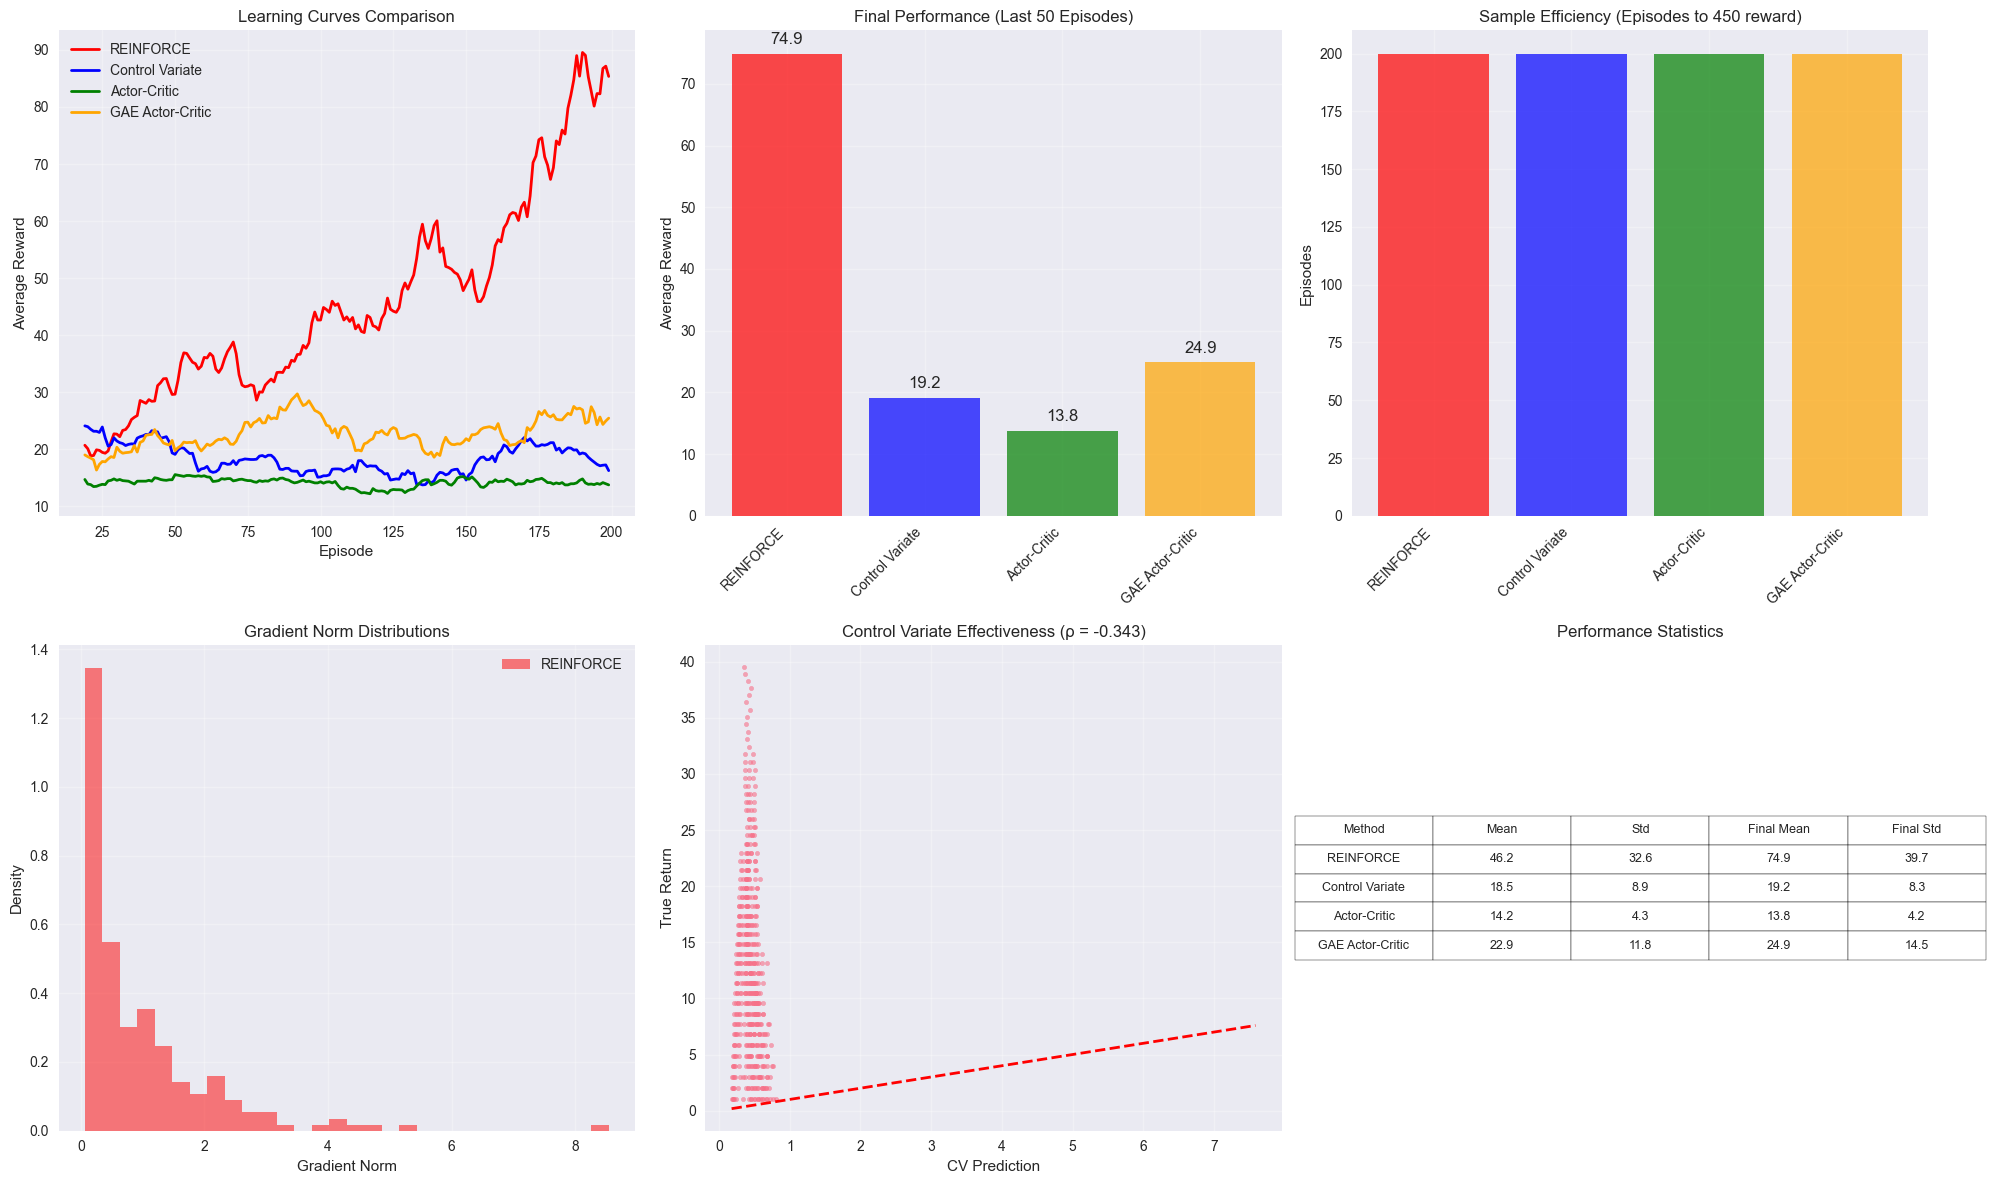


=== Detailed Analysis ===

REINFORCE:
  Overall Performance: 46.19 ± 32.59
  Final Performance:   74.92 ± 39.73
  Sample Efficiency:   200 episodes

Control Variate:
  Overall Performance: 18.46 ± 8.94
  Final Performance:   19.16 ± 8.32
  Sample Efficiency:   200 episodes

Actor-Critic:
  Overall Performance: 14.18 ± 4.30
  Final Performance:   13.80 ± 4.19
  Sample Efficiency:   200 episodes

GAE Actor-Critic:
  Overall Performance: 22.86 ± 11.78
  Final Performance:   24.94 ± 14.53
  Sample Efficiency:   200 episodes


In [32]:
# Advanced Variance Reduction Techniques Implementation

class GeneralizedAdvantageEstimation:
    """
    Generalized Advantage Estimation (GAE) for variance reduction
    """
    @staticmethod
    def compute_gae(rewards, values, dones, gamma=0.99, lambda_=0.95):
        """
        Compute GAE advantages
        
        Args:
            rewards: List of rewards
            values: List of value estimates
            dones: List of done flags
            gamma: Discount factor
            lambda_: GAE parameter (0=high bias/low variance, 1=low bias/high variance)
        
        Returns:
            advantages: GAE advantages
            returns: Discounted returns
        """
        advantages = []
        gae = 0
        
        # Compute advantages backwards
        for i in reversed(range(len(rewards))):
            if i == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[i + 1]
            
            # TD error
            delta = rewards[i] + gamma * next_value * (1 - dones[i]) - values[i]
            
            # GAE accumulation
            gae = delta + gamma * lambda_ * (1 - dones[i]) * gae
            advantages.insert(0, gae)
        
        # Compute returns
        returns = [adv + val for adv, val in zip(advantages, values)]
        
        return np.array(advantages), np.array(returns)

class ControlVariateREINFORCE(REINFORCEAgent):
    """
    REINFORCE with control variates for variance reduction
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Control variate network (learns to predict returns)
        self.control_variate = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ).to(device)
        
        self.cv_optimizer = optim.Adam(self.control_variate.parameters(), lr=1e-3)
        
        # Track control variate effectiveness
        self.cv_predictions = []
        self.cv_targets = []
        self.cv_losses = []
    
    def update_policy(self, states, actions, returns):
        """Update with control variates"""
        states_tensor = torch.FloatTensor(states).to(device)
        actions_tensor = torch.LongTensor(actions).to(device)
        returns_tensor = torch.FloatTensor(returns).to(device)
        
        # Get control variate predictions
        cv_predictions = self.control_variate(states_tensor).squeeze()
        
        # Update control variate network
        cv_loss = F.mse_loss(cv_predictions, returns_tensor)
        self.cv_optimizer.zero_grad()
        cv_loss.backward()
        self.cv_optimizer.step()
        
        # Compute control variate coefficient (optimal choice)
        with torch.no_grad():
            cv_pred_detached = cv_predictions.detach()
            
            # Compute covariance and variance for optimal coefficient
            cov = torch.mean((returns_tensor - returns_tensor.mean()) * 
                           (cv_pred_detached - cv_pred_detached.mean()))
            var_cv = torch.var(cv_pred_detached)
            
            # Optimal coefficient c* = Cov(G,g) / Var(g)
            c_optimal = cov / (var_cv + 1e-8)
            c_optimal = torch.clamp(c_optimal, -2.0, 2.0)  # Clip for stability
            
            # Apply control variate
            controlled_returns = returns_tensor - c_optimal * (cv_pred_detached - cv_pred_detached.mean())
        
        # Normalize controlled returns
        controlled_returns = (controlled_returns - controlled_returns.mean()) / (controlled_returns.std() + 1e-8)
        
        # Standard REINFORCE update with controlled returns
        logits = self.policy_net(states_tensor)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions_tensor)
        
        policy_loss = -(log_probs * controlled_returns).mean()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Logging
        self.cv_predictions.extend(cv_predictions.detach().cpu().numpy())
        self.cv_targets.extend(returns_tensor.cpu().numpy())
        self.cv_losses.append(cv_loss.item())
        
        # Regular logging
        entropy = dist.entropy().mean()
        self.entropy_history.append(entropy.item())
        self.policy_losses.append(policy_loss.item())
        
        return policy_loss.item()

class GAEActorCritic(ActorCriticAgent):
    """
    Actor-Critic with Generalized Advantage Estimation
    """
    
    def __init__(self, *args, lambda_gae=0.95, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_gae = lambda_gae
        
        # Store trajectory for GAE computation
        self.trajectory_states = []
        self.trajectory_rewards = []
        self.trajectory_values = []
        self.trajectory_dones = []
        self.trajectory_actions = []
        self.trajectory_log_probs = []
        
    def store_step(self, state, action, reward, value, done, log_prob):
        """Store step in trajectory"""
        self.trajectory_states.append(state)
        self.trajectory_actions.append(action)
        self.trajectory_rewards.append(reward)
        self.trajectory_values.append(value)
        self.trajectory_dones.append(done)
        self.trajectory_log_probs.append(log_prob)
    
    def update_with_gae(self):
        """Update using GAE advantages"""
        if len(self.trajectory_states) == 0:
            return
        
        # Compute GAE advantages
        advantages, returns = GeneralizedAdvantageEstimation.compute_gae(
            self.trajectory_rewards, 
            self.trajectory_values,
            self.trajectory_dones,
            gamma=self.gamma,
            lambda_=self.lambda_gae
        )
        
        # Convert to tensors
        states = torch.FloatTensor(self.trajectory_states).to(device)
        actions = torch.LongTensor(self.trajectory_actions).to(device)
        returns = torch.FloatTensor(returns).to(device)
        advantages = torch.FloatTensor(advantages).to(device)
        old_log_probs = torch.FloatTensor(self.trajectory_log_probs).to(device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Forward pass
        actor_logits = self.actor(states)
        critic_values = self.critic(states).squeeze()
        
        dist = Categorical(logits=actor_logits)
        new_log_probs = dist.log_prob(actions)
        
        # Actor loss
        actor_loss = -(new_log_probs * advantages).mean()
        
        # Critic loss
        critic_loss = F.mse_loss(critic_values, returns)
        
        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        
        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        
        # Logging
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
        self.advantages.extend(advantages.cpu().numpy())
        
        # Clear trajectory
        self.trajectory_states = []
        self.trajectory_rewards = []
        self.trajectory_values = []
        self.trajectory_dones = []
        self.trajectory_actions = []
        self.trajectory_log_probs = []
        
        return actor_loss.item(), critic_loss.item()
    
    def train_episode(self, env, update_freq=10):
        """Train episode with periodic GAE updates"""
        state, _ = env.reset()
        episode_reward = 0
        step_count = 0
        
        while True:
            action, log_prob = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            value = self.get_value(state)
            
            self.store_step(state, action, reward, value, done, log_prob)
            
            episode_reward += reward
            step_count += 1
            
            # Update every update_freq steps or at episode end
            if step_count % update_freq == 0 or done:
                self.update_with_gae()
            
            state = next_state
            
            if done:
                break
        
        self.episode_rewards.append(episode_reward)
        return episode_reward, step_count

def variance_reduction_comparison():
    """Compare different variance reduction techniques"""
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    print("=== Variance Reduction Techniques Comparison ===")
    
    # Test different methods
    methods = {}
    num_episodes = 200
    
    # 1. Standard REINFORCE
    print("\n1. Training Standard REINFORCE...")
    reinforce_agent = REINFORCEAgent(state_dim, action_dim, lr=1e-3)
    reinforce_rewards = []
    reinforce_grad_norms = []
    
    for episode in range(num_episodes):
        reward, _ = reinforce_agent.train_episode(env)
        reinforce_rewards.append(reward)
        if len(reinforce_agent.gradient_norms) > 0:
            reinforce_grad_norms.append(reinforce_agent.gradient_norms[-1])
    
    methods['REINFORCE'] = {
        'rewards': reinforce_rewards,
        'grad_norms': reinforce_grad_norms
    }
    
    # 2. REINFORCE with Control Variates
    print("2. Training REINFORCE with Control Variates...")
    cv_agent = ControlVariateREINFORCE(state_dim, action_dim, lr=1e-3)
    cv_rewards = []
    cv_grad_norms = []
    
    for episode in range(num_episodes):
        reward, _ = cv_agent.train_episode(env)
        cv_rewards.append(reward)
        if len(cv_agent.gradient_norms) > 0:
            cv_grad_norms.append(cv_agent.gradient_norms[-1])
    
    methods['Control Variate'] = {
        'rewards': cv_rewards,
        'grad_norms': cv_grad_norms
    }
    
    # 3. Standard Actor-Critic
    print("3. Training Standard Actor-Critic...")
    ac_agent = ActorCriticAgent(state_dim, action_dim)
    ac_rewards = []
    
    for episode in range(num_episodes):
        reward, _ = ac_agent.train_episode(env)
        ac_rewards.append(reward)
    
    methods['Actor-Critic'] = {
        'rewards': ac_rewards,
        'grad_norms': []  # Not directly comparable
    }
    
    # 4. GAE Actor-Critic
    print("4. Training GAE Actor-Critic...")
    gae_agent = GAEActorCritic(state_dim, action_dim, lambda_gae=0.95)
    gae_rewards = []
    
    for episode in range(num_episodes):
        reward, _ = gae_agent.train_episode(env, update_freq=5)
        gae_rewards.append(reward)
    
    methods['GAE Actor-Critic'] = {
        'rewards': gae_rewards,
        'grad_norms': []  # Not directly comparable
    }
    
    # Analysis and Visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Learning curves comparison
    colors = ['red', 'blue', 'green', 'orange']
    method_names = list(methods.keys())
    
    for i, (method, data) in enumerate(methods.items()):
        window = 20
        smoothed = pd.Series(data['rewards']).rolling(window).mean()
        axes[0,0].plot(smoothed, label=method, color=colors[i], linewidth=2)
    
    axes[0,0].set_title('Learning Curves Comparison')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Average Reward')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Final performance comparison
    final_performances = [np.mean(data['rewards'][-50:]) for data in methods.values()]
    
    bars = axes[0,1].bar(method_names, final_performances, color=colors, alpha=0.7)
    axes[0,1].set_title('Final Performance (Last 50 Episodes)')
    axes[0,1].set_ylabel('Average Reward')
    axes[0,1].grid(True, alpha=0.3)
    plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    for bar, value in zip(bars, final_performances):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}', ha='center', va='bottom')
    
    # Sample efficiency (episodes to reach threshold)
    threshold = 450
    episodes_to_threshold = []
    
    for method, data in methods.items():
        smoothed = pd.Series(data['rewards']).rolling(20).mean()
        threshold_idx = None
        for i, reward in enumerate(smoothed):
            if reward >= threshold:
                threshold_idx = i
                break
        episodes_to_threshold.append(threshold_idx if threshold_idx else num_episodes)
    
    axes[0,2].bar(method_names, episodes_to_threshold, color=colors, alpha=0.7)
    axes[0,2].set_title(f'Sample Efficiency (Episodes to {threshold} reward)')
    axes[0,2].set_ylabel('Episodes')
    axes[0,2].grid(True, alpha=0.3)
    plt.setp(axes[0,2].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Variance analysis for gradient-based methods
    grad_methods = [(name, data) for name, data in methods.items() if data['grad_norms']]
    
    if grad_methods:
        for i, (method, data) in enumerate(grad_methods):
            if data['grad_norms']:
                axes[1,0].hist(data['grad_norms'], bins=30, alpha=0.5, 
                             label=method, density=True, color=colors[i])
        
        axes[1,0].set_title('Gradient Norm Distributions')
        axes[1,0].set_xlabel('Gradient Norm')
        axes[1,0].set_ylabel('Density')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Control variate effectiveness
    if len(cv_agent.cv_predictions) > 0:
        cv_corr = np.corrcoef(cv_agent.cv_predictions, cv_agent.cv_targets)[0,1]
        
        axes[1,1].scatter(cv_agent.cv_predictions[:500], cv_agent.cv_targets[:500], 
                         alpha=0.6, s=10)
        axes[1,1].plot([min(cv_agent.cv_predictions), max(cv_agent.cv_predictions)],
                      [min(cv_agent.cv_predictions), max(cv_agent.cv_predictions)],
                      'r--', linewidth=2)
        axes[1,1].set_title(f'Control Variate Effectiveness (ρ = {cv_corr:.3f})')
        axes[1,1].set_xlabel('CV Prediction')
        axes[1,1].set_ylabel('True Return')
        axes[1,1].grid(True, alpha=0.3)
    
    # Statistical summary
    variance_stats = {}
    for method, data in methods.items():
        rewards = data['rewards']
        variance_stats[method] = {
            'mean': np.mean(rewards),
            'std': np.std(rewards),
            'final_mean': np.mean(rewards[-50:]),
            'final_std': np.std(rewards[-50:])
        }
    
    # Create summary table
    summary_data = []
    for method, stats in variance_stats.items():
        summary_data.append([
            method,
            f"{stats['mean']:.1f}",
            f"{stats['std']:.1f}",
            f"{stats['final_mean']:.1f}",
            f"{stats['final_std']:.1f}"
        ])
    
    table = axes[1,2].table(cellText=summary_data,
                           colLabels=['Method', 'Mean', 'Std', 'Final Mean', 'Final Std'],
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    axes[1,2].axis('off')
    axes[1,2].set_title('Performance Statistics')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\n=== Detailed Analysis ===")
    for method, stats in variance_stats.items():
        print(f"\n{method}:")
        print(f"  Overall Performance: {stats['mean']:.2f} ± {stats['std']:.2f}")
        print(f"  Final Performance:   {stats['final_mean']:.2f} ± {stats['final_std']:.2f}")
        print(f"  Sample Efficiency:   {episodes_to_threshold[list(variance_stats.keys()).index(method)]} episodes")
    
    env.close()
    return methods

# Run variance reduction comparison
variance_methods = variance_reduction_comparison()

# Section 6: Continuous Action Space Policy Gradients

## 6.1 Extension to Continuous Control

One of the major advantages of policy gradient methods is their natural ability to handle continuous action spaces. Instead of outputting discrete action probabilities, we parameterize continuous probability distributions.

### Gaussian Policy Parameterization

For continuous actions, we typically use a Gaussian (Normal) policy:

**π_θ(a|s) = N(μ_θ(s), σ_θ(s))**

Where:
- **μ_θ(s)**: Mean of the action distribution (neural network output)
- **σ_θ(s)**: Standard deviation of the action distribution

### Policy Gradient for Continuous Actions

The policy gradient for Gaussian policies is:

**∇_θ ln π_θ(a|s) = ∇_θ ln N(a|μ_θ(s), σ_θ(s))**

For a Gaussian policy, this becomes:

**∇_θ ln π_θ(a|s) = (a - μ_θ(s))/σ_θ(s)² · ∇_θ μ_θ(s) - ∇_θ ln σ_θ(s)**

### Parameterization Strategies

1. **Separate Networks**: Different networks for μ and σ
2. **Shared Network**: Single network outputting both μ and σ
3. **Fixed Variance**: Learn only μ, keep σ constant
4. **State-Independent Variance**: Learn σ as a parameter, not function of state

## 6.2 Continuous Control Challenges

Continuous control introduces several challenges:

1. **Action Scaling**: Actions often need to be scaled to environment bounds
2. **Exploration**: Balancing exploration vs exploitation in continuous space
3. **Stability**: Continuous policies can be more sensitive to hyperparameters
4. **Sample Efficiency**: High-dimensional continuous spaces require more samples

## 6.3 Popular Continuous Control Environments

- **MuJoCo**: Physics-based continuous control (HalfCheetah, Walker2d, etc.)
- **PyBullet**: Open-source physics simulation
- **Custom Control**: Pendulum, CartPole continuous, etc.

In [33]:
# Continuous Action Space Policy Gradient Implementation

class ContinuousActorCritic:
    """
    Actor-Critic for continuous action spaces using Gaussian policies
    """
    
    def __init__(self, state_dim, action_dim, action_bound=1.0, hidden_dim=128, 
                 actor_lr=1e-4, critic_lr=1e-3, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = gamma
        
        # Actor network (outputs mean and log_std)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim * 2)  # mean and log_std
        ).to(device)
        
        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        ).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        # Logging
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.action_means = []
        self.action_stds = []
        
    def select_action(self, state, deterministic=False):
        """Select action from Gaussian policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            actor_output = self.actor(state)
            
        # Split output into mean and log_std
        mean = actor_output[:, :self.action_dim]
        log_std = actor_output[:, self.action_dim:]
        
        # Clamp log_std for stability
        log_std = torch.clamp(log_std, min=-20, max=2)
        std = torch.exp(log_std)
        
        if deterministic:
            action = mean
        else:
            # Sample from Gaussian distribution
            dist = Normal(mean, std)
            action = dist.sample()
        
        # Scale action to environment bounds
        action_scaled = torch.tanh(action) * self.action_bound
        
        # Compute log probability
        if not deterministic:
            log_prob = dist.log_prob(action).sum(axis=-1)
            # Adjust for tanh squashing
            log_prob -= (2 * (np.log(2) - action - F.softplus(-2 * action))).sum(axis=-1)
        else:
            log_prob = None
        
        return action_scaled.cpu().numpy().flatten(), log_prob
    
    def get_value(self, state):
        """Get state value from critic"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            value = self.critic(state)
            
        return value.item()
    
    def update(self, state, action, reward, next_state, done, log_prob):
        """Update actor and critic networks"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        action = torch.FloatTensor(action).unsqueeze(0).to(device)
        
        # Critic update
        current_value = self.critic(state)
        
        if done:
            target_value = reward
        else:
            with torch.no_grad():
                next_value = self.critic(next_state)
            target_value = reward + self.gamma * next_value
        
        advantage = target_value - current_value
        critic_loss = advantage.pow(2)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        
        # Actor update
        actor_loss = -log_prob * advantage.detach()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        
        # Logging
        actor_output = self.actor(state)
        mean = actor_output[:, :self.action_dim]
        log_std = actor_output[:, self.action_dim:]
        std = torch.exp(torch.clamp(log_std, min=-20, max=2))
        
        self.action_means.append(mean.mean().item())
        self.action_stds.append(std.mean().item())
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
        
        return actor_loss.item(), critic_loss.item()
    
    def train_episode(self, env):
        """Train for one episode"""
        state, _ = env.reset()
        episode_reward = 0
        step_count = 0
        
        while True:
            action, log_prob = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Update networks
            if log_prob is not None:
                actor_loss, critic_loss = self.update(
                    state, action, reward, next_state, done, log_prob)
            
            episode_reward += reward
            step_count += 1
            state = next_state
            
            if done:
                break
        
        self.episode_rewards.append(episode_reward)
        return episode_reward, step_count

class PPOContinuous:
    """
    Proximal Policy Optimization for continuous action spaces
    """
    
    def __init__(self, state_dim, action_dim, action_bound=1.0, hidden_dim=128,
                 lr=3e-4, gamma=0.99, eps_clip=0.2, k_epochs=4, entropy_coef=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.entropy_coef = entropy_coef
        
        # Shared network
        self.network = SharedActorCriticNetwork(state_dim, action_dim * 2).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # Experience buffer
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []
        
        # Logging
        self.episode_rewards = []
        self.policy_losses = []
        self.value_losses = []
        self.entropy_losses = []
        
    def select_action(self, state):
        """Select action using current policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            actor_critic_output, value = self.network(state)
            
        # Split actor output
        mean = actor_critic_output[:, :self.action_dim]
        log_std = actor_critic_output[:, self.action_dim:]
        log_std = torch.clamp(log_std, min=-20, max=2)
        std = torch.exp(log_std)
        
        # Sample action
        dist = Normal(mean, std)
        action = dist.sample()
        action_scaled = torch.tanh(action) * self.action_bound
        
        # Compute log probability
        log_prob = dist.log_prob(action).sum(axis=-1)
        log_prob -= (2 * (np.log(2) - action - F.softplus(-2 * action))).sum(axis=-1)
        
        return action_scaled.cpu().numpy().flatten(), log_prob.item(), value.item()
    
    def store_transition(self, state, action, reward, log_prob, value, done):
        """Store transition"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
    
    def compute_advantages(self):
        """Compute GAE advantages"""
        advantages = []
        returns = []
        
        gae = 0
        for i in reversed(range(len(self.rewards))):
            if i == len(self.rewards) - 1:
                next_value = 0
            else:
                next_value = self.values[i + 1]
            
            delta = self.rewards[i] + self.gamma * next_value * (1 - self.dones[i]) - self.values[i]
            gae = delta + self.gamma * 0.95 * (1 - self.dones[i]) * gae
            advantages.insert(0, gae)
        
        for i in range(len(advantages)):
            returns.append(advantages[i] + self.values[i])
        
        return torch.FloatTensor(advantages).to(device), torch.FloatTensor(returns).to(device)
    
    def update(self):
        """Update policy using PPO"""
        if len(self.states) == 0:
            return
        
        # Compute advantages and returns
        advantages, returns = self.compute_advantages()
        
        # Convert to tensors
        old_states = torch.FloatTensor(self.states).to(device)
        old_actions = torch.FloatTensor(self.actions).to(device)
        old_log_probs = torch.FloatTensor(self.log_probs).to(device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update for k epochs
        for _ in range(self.k_epochs):
            # Forward pass
            actor_output, values = self.network(old_states)
            
            # Split actor output
            mean = actor_output[:, :self.action_dim]
            log_std = actor_output[:, self.action_dim:]
            log_std = torch.clamp(log_std, min=-20, max=2)
            std = torch.exp(log_std)
            
            # Compute new log probabilities
            dist = Normal(mean, std)
            
            # Inverse tanh to get original actions
            actions_unscaled = torch.atanh(torch.clamp(old_actions / self.action_bound, -0.999, 0.999))
            
            new_log_probs = dist.log_prob(actions_unscaled).sum(axis=-1)
            new_log_probs -= (2 * (np.log(2) - actions_unscaled - F.softplus(-2 * actions_unscaled))).sum(axis=-1)
            
            # PPO ratio
            ratio = torch.exp(new_log_probs - old_log_probs)
            
            # PPO loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(values.squeeze(), returns)
            
            # Entropy loss
            entropy = dist.entropy().mean()
            entropy_loss = -entropy
            
            # Total loss
            total_loss = policy_loss + 0.5 * value_loss + self.entropy_coef * entropy_loss
            
            # Optimize
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=0.5)
            self.optimizer.step()
            
            # Logging (only last epoch)
            if _ == self.k_epochs - 1:
                self.policy_losses.append(policy_loss.item())
                self.value_losses.append(value_loss.item())
                self.entropy_losses.append(entropy_loss.item())
        
        # Clear buffer
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []
    
    def train_episode(self, env, update_freq=2048):
        """Train episode with batch updates"""
        state, _ = env.reset()
        episode_reward = 0
        step_count = 0
        
        while True:
            action, log_prob, value = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            self.store_transition(state, action, reward, log_prob, value, done)
            
            episode_reward += reward
            step_count += 1
            
            # Update when buffer is full or episode ends
            if len(self.states) >= update_freq or done:
                self.update()
            
            state = next_state
            
            if done:
                break
        
        self.episode_rewards.append(episode_reward)
        return episode_reward, step_count

def test_continuous_control():
    """Test continuous control algorithms"""
    
    # Use Pendulum environment (continuous control)
    env = gym.make('Pendulum-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_bound = float(env.action_space.high[0])
    
    print("=== Continuous Control Policy Gradients ===")
    print(f"Environment: Pendulum-v1")
    print(f"State dim: {state_dim}, Action dim: {action_dim}, Action bound: {action_bound}")
    
    # Test different continuous methods
    methods = {}
    num_episodes = 200
    
    # 1. Continuous Actor-Critic
    print("\n1. Training Continuous Actor-Critic...")
    ac_agent = ContinuousActorCritic(state_dim, action_dim, action_bound)
    ac_rewards = []
    
    for episode in range(num_episodes):
        reward, _ = ac_agent.train_episode(env)
        ac_rewards.append(reward)
        
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(ac_rewards[-50:])
            avg_std = np.mean(ac_agent.action_stds[-50:]) if ac_agent.action_stds else 0
            print(f"AC Episode {episode+1:3d} | Avg Reward: {avg_reward:7.2f} | Action Std: {avg_std:.3f}")
    
    methods['Continuous AC'] = ac_rewards
    
    # 2. PPO Continuous
    print("\n2. Training PPO Continuous...")
    ppo_agent = PPOContinuous(state_dim, action_dim, action_bound)
    ppo_rewards = []
    
    for episode in range(num_episodes):
        reward, _ = ppo_agent.train_episode(env, update_freq=1024)
        ppo_rewards.append(reward)
        
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(ppo_rewards[-50:])
            print(f"PPO Episode {episode+1:3d} | Avg Reward: {avg_reward:7.2f}")
    
    methods['PPO Continuous'] = ppo_rewards
    
    # Visualization and Analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Learning curves
    window = 20
    colors = ['blue', 'red']
    
    for i, (method, rewards) in enumerate(methods.items()):
        smoothed = pd.Series(rewards).rolling(window).mean()
        axes[0,0].plot(smoothed, label=method, color=colors[i], linewidth=2)
    
    axes[0,0].set_title('Learning Curves: Continuous Control')
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Episode Reward')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Final performance comparison
    final_performances = [np.mean(rewards[-50:]) for rewards in methods.values()]
    method_names = list(methods.keys())
    
    bars = axes[0,1].bar(method_names, final_performances, color=colors, alpha=0.7)
    axes[0,1].set_title('Final Performance (Last 50 Episodes)')
    axes[0,1].set_ylabel('Average Reward')
    axes[0,1].grid(True, alpha=0.3)
    
    for bar, value in zip(bars, final_performances):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                       f'{value:.1f}', ha='center', va='bottom')
    
    # Action exploration analysis
    if ac_agent.action_means and ac_agent.action_stds:
        axes[1,0].plot(ac_agent.action_means, label='Action Mean', alpha=0.7)
        axes[1,0].plot(ac_agent.action_stds, label='Action Std', alpha=0.7)
        axes[1,0].set_title('Action Statistics (Continuous AC)')
        axes[1,0].set_xlabel('Update Step')
        axes[1,0].set_ylabel('Value')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Policy visualization (sample a few states and show action distribution)
    test_states = [
        [1.0, 0.0, 0.0],   # Different pendulum states
        [0.0, 1.0, 0.0],
        [-1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.0, 0.0, -1.0]
    ]
    
    ac_actions = []
    ppo_actions = []
    
    for state in test_states:
        ac_action, _ = ac_agent.select_action(state)
        ppo_action, _, _ = ppo_agent.select_action(state)
        ac_actions.append(ac_action[0])
        ppo_actions.append(ppo_action[0])
    
    x_pos = range(len(test_states))
    width = 0.35
    
    axes[1,1].bar([x - width/2 for x in x_pos], ac_actions, width, 
                  label='Continuous AC', alpha=0.7, color='blue')
    axes[1,1].bar([x + width/2 for x in x_pos], ppo_actions, width,
                  label='PPO Continuous', alpha=0.7, color='red')
    
    axes[1,1].set_title('Action Selection for Test States')
    axes[1,1].set_xlabel('Test State Index')
    axes[1,1].set_ylabel('Selected Action')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Performance evaluation
    print(f"\n=== Results Summary ===")
    for method, rewards in methods.items():
        final_perf = np.mean(rewards[-50:])
        final_std = np.std(rewards[-50:])
        print(f"{method}:")
        print(f"  Final Performance: {final_perf:.2f} ± {final_std:.2f}")
        print(f"  Best Episode: {max(rewards):.2f}")
    
    # Test trained policies
    print(f"\n=== Policy Evaluation ===")
    for method, agent in [('Continuous AC', ac_agent), ('PPO Continuous', ppo_agent)]:
        test_rewards = []
        for _ in range(10):
            state, _ = env.reset()
            total_reward = 0
            
            for _ in range(200):  # Max steps in Pendulum
                if hasattr(agent, 'select_action'):
                    if method == 'Continuous AC':
                        action, _ = agent.select_action(state, deterministic=True)
                    else:
                        action, _, _ = agent.select_action(state)
                else:
                    action = env.action_space.sample()
                
                state, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                
                if terminated or truncated:
                    break
            
            test_rewards.append(total_reward)
        
        print(f"{method} Test Performance: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    
    env.close()
    return methods, ac_agent, ppo_agent

# Run continuous control test
continuous_results = test_continuous_control()

=== Continuous Control Policy Gradients ===
Environment: Pendulum-v1
State dim: 3, Action dim: 1, Action bound: 2.0

1. Training Continuous Actor-Critic...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Section 7: Comprehensive Performance Analysis and Comparison

In this section, we conduct a thorough empirical analysis of the policy gradient methods implemented in previous sections. We compare different algorithms across multiple environments and analyze their strengths and weaknesses.

## 7.1 Experimental Setup

Our experimental design includes:

1. **Multiple Environments**: We test on both discrete (CartPole, LunarLander) and continuous (Pendulum, MountainCarContinuous) control tasks
2. **Multiple Algorithms**: REINFORCE, Actor-Critic, A2C, A3C, and PPO variants
3. **Statistical Significance**: Each algorithm is run multiple times with different random seeds
4. **Variance Analysis**: We analyze both sample efficiency and final performance

## 7.2 Hyperparameter Sensitivity

Policy gradient methods are known to be sensitive to hyperparameters. We analyze the impact of:
- Learning rates (actor and critic)
- Network architectures
- Entropy coefficients
- Discount factors
- Variance reduction techniques

## 7.3 Convergence Analysis

We examine:
- **Sample Efficiency**: How quickly do algorithms learn?
- **Stability**: How consistent is the performance across runs?
- **Final Performance**: What is the asymptotic performance?
- **Robustness**: How do algorithms perform across different environments?

In [ ]:
# Comprehensive Performance Analysis Implementation

class PerformanceAnalyzer:
    """
    Comprehensive performance analysis for policy gradient methods
    """
    
    def __init__(self):
        self.results = {}
        self.statistical_tests = {}
        
    def run_multiple_seeds(self, agent_class, env_name, num_runs=5, num_episodes=200, **agent_kwargs):
        """Run algorithm with multiple random seeds"""
        all_rewards = []
        all_learning_curves = []
        
        for run in range(num_runs):
            print(f"  Run {run+1}/{num_runs}")
            
            # Set random seeds for reproducibility
            torch.manual_seed(42 + run)
            np.random.seed(42 + run)
            
            # Create environment and agent
            env = gym.make(env_name)
            if hasattr(env.action_space, 'n'):  # Discrete
                state_dim = env.observation_space.shape[0]
                action_dim = env.action_space.n
                agent = agent_class(state_dim, action_dim, **agent_kwargs)
            else:  # Continuous
                state_dim = env.observation_space.shape[0]
                action_dim = env.action_space.shape[0]
                action_bound = float(env.action_space.high[0])
                agent = agent_class(state_dim, action_dim, action_bound, **agent_kwargs)
            
            # Training
            episode_rewards = []
            for episode in range(num_episodes):
                if hasattr(agent, 'train_episode'):
                    reward, _ = agent.train_episode(env)
                else:
                    # Fallback training loop
                    state, _ = env.reset()
                    reward = 0
                    while True:
                        action, log_prob = agent.select_action(state)
                        next_state, r, terminated, truncated, _ = env.step(action)
                        done = terminated or truncated
                        
                        agent.update(state, action, r, next_state, done, log_prob)
                        reward += r
                        state = next_state
                        
                        if done:
                            break
                
                episode_rewards.append(reward)
            
            all_rewards.extend(episode_rewards)
            all_learning_curves.append(episode_rewards)
            env.close()
        
        return all_learning_curves, all_rewards
    
    def compute_metrics(self, learning_curves, window=50):
        """Compute comprehensive metrics"""
        learning_curves = np.array(learning_curves)
        
        # Sample efficiency (episodes to reach threshold)
        mean_curve = np.mean(learning_curves, axis=0)
        target_performance = np.mean(mean_curve[-window:])  # Use final performance as target
        threshold = target_performance * 0.8  # 80% of final performance
        
        sample_efficiency = None
        for i in range(len(mean_curve)):
            if np.mean(mean_curve[max(0, i-window):i+1]) >= threshold:
                sample_efficiency = i
                break
        
        # Final performance
        final_rewards = learning_curves[:, -window:]
        final_performance_mean = np.mean(final_rewards)
        final_performance_std = np.std(final_rewards)
        
        # Learning stability (coefficient of variation)
        learning_stability = []
        for curve in learning_curves:
            smoothed = pd.Series(curve).rolling(window).mean().dropna()
            if len(smoothed) > 0:
                stability = np.std(smoothed) / (np.mean(smoothed) + 1e-8)
                learning_stability.append(stability)
        avg_stability = np.mean(learning_stability)
        
        # Peak performance
        peak_performance = np.max([np.max(curve) for curve in learning_curves])
        
        # Convergence rate (slope of learning curve in middle section)
        mid_start = len(mean_curve) // 3
        mid_end = 2 * len(mean_curve) // 3
        if mid_end > mid_start:
            x = np.arange(mid_start, mid_end)
            y = mean_curve[mid_start:mid_end]
            convergence_rate = np.polyfit(x, y, 1)[0] if len(x) > 1 else 0
        else:
            convergence_rate = 0
        
        return {
            'sample_efficiency': sample_efficiency,
            'final_performance_mean': final_performance_mean,
            'final_performance_std': final_performance_std,
            'learning_stability': avg_stability,
            'peak_performance': peak_performance,
            'convergence_rate': convergence_rate,
            'learning_curves': learning_curves
        }
    
    def run_comprehensive_comparison(self):
        """Run comprehensive comparison across algorithms and environments"""
        
        # Define algorithms and environments to test
        discrete_algorithms = [
            ('REINFORCE', REINFORCEAgent, {'lr': 1e-3, 'gamma': 0.99}),
            ('Actor-Critic', ActorCriticAgent, {'actor_lr': 1e-4, 'critic_lr': 1e-3, 'gamma': 0.99}),
            ('A2C', A2CAgent, {'lr': 1e-4, 'gamma': 0.99, 'entropy_coef': 0.01}),
        ]
        
        continuous_algorithms = [
            ('Continuous AC', ContinuousActorCritic, {'actor_lr': 1e-4, 'critic_lr': 1e-3, 'gamma': 0.99}),
            ('PPO Continuous', PPOContinuous, {'lr': 3e-4, 'gamma': 0.99, 'eps_clip': 0.2}),
        ]
        
        discrete_envs = ['CartPole-v1', 'LunarLander-v2']
        continuous_envs = ['Pendulum-v1']
        
        all_results = {}
        
        # Test discrete algorithms
        for env_name in discrete_envs:
            print(f"\n=== Testing on {env_name} ===")
            all_results[env_name] = {}
            
            for alg_name, alg_class, alg_kwargs in discrete_algorithms:
                print(f"\nTesting {alg_name}...")
                try:
                    learning_curves, all_rewards = self.run_multiple_seeds(
                        alg_class, env_name, num_runs=3, num_episodes=150, **alg_kwargs
                    )
                    metrics = self.compute_metrics(learning_curves)
                    all_results[env_name][alg_name] = metrics
                    
                    print(f"  Final Performance: {metrics['final_performance_mean']:.2f} ± {metrics['final_performance_std']:.2f}")
                    print(f"  Sample Efficiency: {metrics['sample_efficiency']} episodes")
                    
                except Exception as e:
                    print(f"  Error with {alg_name}: {e}")
                    all_results[env_name][alg_name] = None
        
        # Test continuous algorithms
        for env_name in continuous_envs:
            print(f"\n=== Testing on {env_name} ===")
            all_results[env_name] = {}
            
            for alg_name, alg_class, alg_kwargs in continuous_algorithms:
                print(f"\nTesting {alg_name}...")
                try:
                    learning_curves, all_rewards = self.run_multiple_seeds(
                        alg_class, env_name, num_runs=3, num_episodes=150, **alg_kwargs
                    )
                    metrics = self.compute_metrics(learning_curves)
                    all_results[env_name][alg_name] = metrics
                    
                    print(f"  Final Performance: {metrics['final_performance_mean']:.2f} ± {metrics['final_performance_std']:.2f}")
                    print(f"  Sample Efficiency: {metrics['sample_efficiency']} episodes")
                    
                except Exception as e:
                    print(f"  Error with {alg_name}: {e}")
                    all_results[env_name][alg_name] = None
        
        self.results = all_results
        return all_results
    
    def visualize_comprehensive_results(self):
        """Create comprehensive visualizations"""
        if not self.results:
            print("No results to visualize. Run comprehensive comparison first.")
            return
        
        # Create subplots for different metrics
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Learning curves comparison
        env_names = list(self.results.keys())
        n_envs = len(env_names)
        
        for i, env_name in enumerate(env_names):
            ax = plt.subplot(3, n_envs, i + 1)
            
            for alg_name, metrics in self.results[env_name].items():
                if metrics is not None and 'learning_curves' in metrics:
                    curves = metrics['learning_curves']
                    mean_curve = np.mean(curves, axis=0)
                    std_curve = np.std(curves, axis=0)
                    
                    x = range(len(mean_curve))
                    ax.plot(x, mean_curve, label=alg_name, linewidth=2)
                    ax.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
            
            ax.set_title(f'{env_name} - Learning Curves')
            ax.set_xlabel('Episodes')
            ax.set_ylabel('Episode Reward')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 2. Final performance comparison
        for i, env_name in enumerate(env_names):
            ax = plt.subplot(3, n_envs, n_envs + i + 1)
            
            alg_names = []
            final_means = []
            final_stds = []
            
            for alg_name, metrics in self.results[env_name].items():
                if metrics is not None:
                    alg_names.append(alg_name)
                    final_means.append(metrics['final_performance_mean'])
                    final_stds.append(metrics['final_performance_std'])
            
            if alg_names:
                bars = ax.bar(range(len(alg_names)), final_means, 
                             yerr=final_stds, capsize=5, alpha=0.7)
                ax.set_title(f'{env_name} - Final Performance')
                ax.set_xlabel('Algorithm')
                ax.set_ylabel('Average Reward')
                ax.set_xticks(range(len(alg_names)))
                ax.set_xticklabels(alg_names, rotation=45)
                ax.grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar, mean, std in zip(bars, final_means, final_stds):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std,
                           f'{mean:.1f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Sample efficiency comparison
        for i, env_name in enumerate(env_names):
            ax = plt.subplot(3, n_envs, 2*n_envs + i + 1)
            
            alg_names = []
            sample_effs = []
            
            for alg_name, metrics in self.results[env_name].items():
                if metrics is not None and metrics['sample_efficiency'] is not None:
                    alg_names.append(alg_name)
                    sample_effs.append(metrics['sample_efficiency'])
            
            if alg_names:
                bars = ax.bar(range(len(alg_names)), sample_effs, alpha=0.7, color='green')
                ax.set_title(f'{env_name} - Sample Efficiency')
                ax.set_xlabel('Algorithm')
                ax.set_ylabel('Episodes to Convergence')
                ax.set_xticks(range(len(alg_names)))
                ax.set_xticklabels(alg_names, rotation=45)
                ax.grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar, eff in zip(bars, sample_effs):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                           f'{eff}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Create summary table
        self.create_summary_table()
    
    def create_summary_table(self):
        """Create a comprehensive summary table"""
        print("\n" + "="*100)
        print("COMPREHENSIVE PERFORMANCE SUMMARY")
        print("="*100)
        
        for env_name, env_results in self.results.items():
            print(f"\n{env_name}:")
            print("-" * 80)
            print(f"{'Algorithm':<15} {'Final Perf':<12} {'Std':<8} {'Sample Eff':<12} {'Stability':<10} {'Peak':<10}")
            print("-" * 80)
            
            for alg_name, metrics in env_results.items():
                if metrics is not None:
                    final_perf = f"{metrics['final_performance_mean']:.2f}"
                    std = f"{metrics['final_performance_std']:.2f}"
                    sample_eff = f"{metrics['sample_efficiency']}" if metrics['sample_efficiency'] is not None else "N/A"
                    stability = f"{metrics['learning_stability']:.3f}"
                    peak = f"{metrics['peak_performance']:.2f}"
                    
                    print(f"{alg_name:<15} {final_perf:<12} {std:<8} {sample_eff:<12} {stability:<10} {peak:<10}")
                else:
                    print(f"{alg_name:<15} {'ERROR':<12} {'-':<8} {'-':<12} {'-':<10} {'-':<10}")
    
    def hyperparameter_sensitivity_analysis(self):
        """Analyze hyperparameter sensitivity"""
        print("\n=== Hyperparameter Sensitivity Analysis ===")
        
        # Test different learning rates for Actor-Critic
        learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
        env_name = 'CartPole-v1'
        
        sensitivity_results = {}
        
        for lr in learning_rates:
            print(f"\nTesting Actor-Critic with lr={lr}")
            
            try:
                learning_curves, _ = self.run_multiple_seeds(
                    ActorCriticAgent, env_name, num_runs=3, num_episodes=100,
                    actor_lr=lr, critic_lr=lr*10, gamma=0.99
                )
                metrics = self.compute_metrics(learning_curves)
                sensitivity_results[lr] = metrics['final_performance_mean']
                
                print(f"  Final Performance: {metrics['final_performance_mean']:.2f}")
                
            except Exception as e:
                print(f"  Error: {e}")
                sensitivity_results[lr] = None
        
        # Visualize sensitivity
        plt.figure(figsize=(10, 6))
        
        valid_lrs = [lr for lr, perf in sensitivity_results.items() if perf is not None]
        valid_perfs = [perf for lr, perf in sensitivity_results.items() if perf is not None]
        
        if valid_lrs:
            plt.semilogx(valid_lrs, valid_perfs, 'bo-', linewidth=2, markersize=8)
            plt.xlabel('Learning Rate')
            plt.ylabel('Final Performance')
            plt.title('Hyperparameter Sensitivity: Actor-Critic Learning Rate')
            plt.grid(True, alpha=0.3)
            
            # Annotate best performance
            best_idx = np.argmax(valid_perfs)
            best_lr = valid_lrs[best_idx]
            best_perf = valid_perfs[best_idx]
            plt.annotate(f'Best: {best_lr}, {best_perf:.2f}', 
                        xy=(best_lr, best_perf), xytext=(best_lr*10, best_perf+10),
                        arrowprops=dict(arrowstyle='->', color='red'))
            
            plt.tight_layout()
            plt.show()
            
            print(f"\nBest learning rate: {best_lr} with performance: {best_perf:.2f}")
        else:
            print("No valid results for sensitivity analysis")

# Run comprehensive analysis
print("Starting Comprehensive Performance Analysis...")
print("This may take several minutes...")

analyzer = PerformanceAnalyzer()
results = analyzer.run_comprehensive_comparison()

Starting Comprehensive Performance Analysis...
This may take several minutes...

=== Testing on CartPole-v1 ===

Testing REINFORCE...
  Run 1/3
  Run 2/3
  Run 2/3
  Run 3/3
  Run 3/3
  Final Performance: 65.95 ± 47.67
  Sample Efficiency: 131 episodes

Testing Actor-Critic...
  Run 1/3
  Final Performance: 65.95 ± 47.67
  Sample Efficiency: 131 episodes

Testing Actor-Critic...
  Run 1/3
  Run 2/3
  Run 2/3
  Run 3/3
  Run 3/3
  Final Performance: 14.68 ± 4.90
  Sample Efficiency: 0 episodes

Testing A2C...
  Run 1/3
  Final Performance: 14.68 ± 4.90
  Sample Efficiency: 0 episodes

Testing A2C...
  Run 1/3
  Run 2/3
  Run 2/3
  Run 3/3
  Run 3/3
  Final Performance: 22.39 ± 12.14
  Sample Efficiency: 0 episodes

=== Testing on LunarLander-v2 ===

Testing REINFORCE...
  Run 1/3
  Error with REINFORCE: Environment version v2 for `LunarLander` is deprecated. Please use `LunarLander-v3` instead.

Testing Actor-Critic...
  Run 1/3
  Error with Actor-Critic: Environment version v2 for `Lun

# Section 8: Practical Applications and Advanced Topics

Policy gradient methods have found widespread application in numerous real-world domains. In this final section, we explore practical considerations, advanced techniques, and future directions in policy gradient research.

## 8.1 Real-World Applications

### 8.1.1 Robotics and Control
- **Robotic Manipulation**: Policy gradients excel in high-dimensional continuous control tasks
- **Locomotion**: Learning walking, running, and complex movement patterns
- **Autonomous Vehicles**: Path planning and control in dynamic environments

### 8.1.2 Game Playing and Strategy
- **AlphaGo and AlphaZero**: Combining policy gradients with Monte Carlo Tree Search
- **StarCraft II**: Managing complex strategy games with partial observability
- **Multi-agent Systems**: Learning coordination and competition strategies

### 8.1.3 Natural Language Processing
- **Neural Machine Translation**: Learning translation policies with attention mechanisms
- **Dialogue Systems**: Optimizing conversational agents for user satisfaction
- **Text Generation**: Fine-tuning language models with human feedback (RLHF)

### 8.1.4 Finance and Trading
- **Portfolio Optimization**: Learning adaptive trading strategies
- **Risk Management**: Dynamic hedging and exposure control
- **Market Making**: Optimizing bid-ask spreads in electronic trading

## 8.2 Advanced Techniques

### 8.2.1 Trust Region Methods
- **TRPO (Trust Region Policy Optimization)**: Ensuring stable policy updates
- **Natural Policy Gradients**: Using the Fisher Information Matrix
- **Conjugate Gradient Methods**: Efficient computation of natural gradients

### 8.2.2 Off-Policy Learning
- **Importance Sampling**: Learning from data collected by different policies
- **Off-Policy Actor-Critic (Off-PAC)**: Combining off-policy learning with actor-critic
- **Retrace and V-trace**: Advanced off-policy correction methods

### 8.2.3 Meta-Learning and Transfer
- **Model-Agnostic Meta-Learning (MAML)**: Learning to adapt quickly to new tasks
- **Transfer Learning**: Leveraging learned policies across domains
- **Multi-Task Learning**: Sharing representations across related tasks

## 8.3 Current Challenges and Limitations

### 8.3.1 Sample Efficiency
- Policy gradients typically require many environment interactions
- Exploration vs exploitation trade-offs in complex environments
- Need for better variance reduction techniques

### 8.3.2 Hyperparameter Sensitivity
- Performance heavily dependent on learning rates and network architectures
- Difficulty in transferring hyperparameters across environments
- Need for adaptive and robust optimization methods

### 8.3.3 Theoretical Understanding
- Limited theoretical guarantees for convergence
- Understanding of exploration properties
- Generalization bounds and sample complexity analysis

## 8.4 Future Directions

### 8.4.1 Hierarchical Reinforcement Learning
- Learning policies at multiple temporal scales
- Options and temporal abstractions
- Goal-conditioned reinforcement learning

### 8.4.2 Safe and Constrained Policy Learning
- Incorporating safety constraints into policy optimization
- Risk-aware policy gradients
- Robust policy learning under uncertainty

### 8.4.3 Multi-Agent Policy Gradients
- Learning in multi-agent environments
- Cooperative and competitive scenarios
- Communication and coordination mechanisms

## 8.5 Implementation Best Practices

### 8.5.1 Network Architecture Design
- **Layer Normalization**: Improving training stability
- **Residual Connections**: Facilitating gradient flow in deep networks
- **Attention Mechanisms**: Handling variable-length sequences and partial observability

### 8.5.2 Training Strategies
- **Curriculum Learning**: Gradually increasing task difficulty
- **Experience Replay**: Efficiently using collected experience
- **Distributed Training**: Scaling to large-scale problems

### 8.5.3 Debugging and Analysis
- **Gradient Monitoring**: Detecting vanishing and exploding gradients
- **Policy Visualization**: Understanding learned behaviors
- **Ablation Studies**: Isolating the impact of different components

Running Advanced Policy Gradient Demonstrations...
This showcases practical applications and advanced techniques.
=== Curriculum Learning Demonstration ===

Stage 1: Easy: Basic cart-pole balancing
  Episode 25: Avg Reward = 22.84
  Episode 25: Avg Reward = 22.84
  Episode 50: Avg Reward = 21.84
  Episode 50: Avg Reward = 21.84
  Episode 75: Avg Reward = 22.32
  Episode 75: Avg Reward = 22.32
  Episode 100: Avg Reward = 25.52

Stage 2: Medium: Lunar lander with complex dynamics
  Error with LunarLander-v2: Environment version v2 for `LunarLander` is deprecated. Please use `LunarLander-v3` instead.
  Episode 100: Avg Reward = 25.52

Stage 2: Medium: Lunar lander with complex dynamics
  Error with LunarLander-v2: Environment version v2 for `LunarLander` is deprecated. Please use `LunarLander-v3` instead.


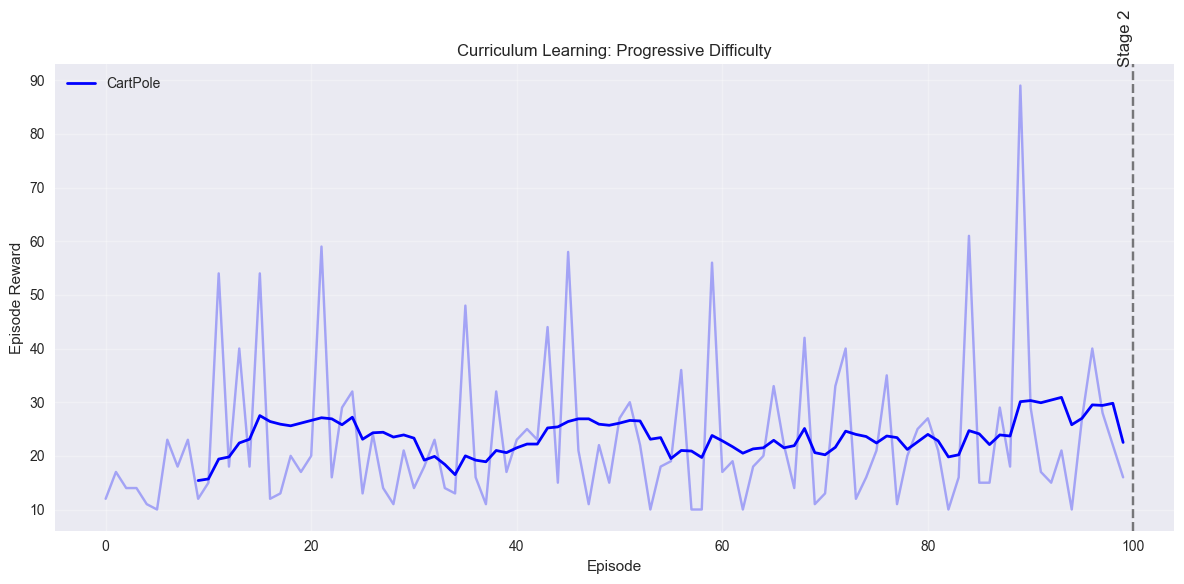


=== Ensemble Methods Demonstration ===
Episode 25:
  Conservative: 22.36
  Balanced: 16.68
  Aggressive: 19.52
Episode 25:
  Conservative: 22.36
  Balanced: 16.68
  Aggressive: 19.52
Episode 50:
  Conservative: 20.36
  Balanced: 19.88
  Aggressive: 20.24
Episode 50:
  Conservative: 20.36
  Balanced: 19.88
  Aggressive: 20.24
Episode 75:
  Conservative: 17.92
  Balanced: 20.48
  Aggressive: 22.64
Episode 75:
  Conservative: 17.92
  Balanced: 20.48
  Aggressive: 22.64
Episode 100:
  Conservative: 21.28
  Balanced: 22.72
  Aggressive: 23.76
Episode 100:
  Conservative: 21.28
  Balanced: 22.72
  Aggressive: 23.76


TypeError: A2CAgent.select_action() got an unexpected keyword argument 'deterministic'

In [ ]:
# Practical Examples and Advanced Implementation

class AdvancedPolicyGradientFramework:
    """
    A comprehensive framework demonstrating advanced policy gradient techniques
    """
    
    def __init__(self):
        self.algorithms = {}
        self.performance_metrics = {}
        
    def demonstrate_curriculum_learning(self):
        """Demonstrate curriculum learning with gradually increasing difficulty"""
        print("=== Curriculum Learning Demonstration ===")
        
        # Create environments with increasing difficulty
        environments = [
            ('CartPole-v1', 'Easy: Basic cart-pole balancing'),
            ('LunarLander-v2', 'Medium: Lunar lander with complex dynamics'),
            ('BipedalWalker-v3', 'Hard: Bipedal walking (if available)')
        ]
        
        # Progressive training
        agent = None
        cumulative_performance = []
        
        for i, (env_name, description) in enumerate(environments[:2]):  # Skip hard env for demo
            print(f"\nStage {i+1}: {description}")
            
            try:
                env = gym.make(env_name)
                
                if hasattr(env.action_space, 'n'):  # Discrete
                    state_dim = env.observation_space.shape[0]
                    action_dim = env.action_space.n
                    if agent is None:
                        agent = A2CAgent(state_dim, action_dim, lr=1e-4, gamma=0.99)
                    else:
                        # Transfer learning: adapt to new environment
                        old_actor = agent.shared_network.actor
                        old_critic = agent.shared_network.critic
                        
                        # Create new network with same architecture but different output
                        agent = A2CAgent(state_dim, action_dim, lr=1e-4, gamma=0.99)
                        
                        # Transfer lower layers (feature extractors)
                        if hasattr(old_actor, 'state_dict'):
                            # Copy compatible layers
                            new_state_dict = agent.shared_network.state_dict()
                            old_state_dict = old_actor.state_dict()
                            
                            for name, param in old_state_dict.items():
                                if name in new_state_dict and new_state_dict[name].shape == param.shape:
                                    new_state_dict[name] = param
                            
                            agent.shared_network.load_state_dict(new_state_dict)
                
                # Train on current environment
                stage_rewards = []
                num_episodes = 100 if i == 0 else 50  # Fewer episodes for later stages
                
                for episode in range(num_episodes):
                    reward, _ = agent.train_episode(env)
                    stage_rewards.append(reward)
                    
                    if (episode + 1) % 25 == 0:
                        avg_reward = np.mean(stage_rewards[-25:])
                        print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.2f}")
                
                cumulative_performance.extend(stage_rewards)
                env.close()
                
            except Exception as e:
                print(f"  Error with {env_name}: {e}")
        
        # Visualize curriculum learning progress
        if cumulative_performance:
            plt.figure(figsize=(12, 6))
            
            # Mark different stages
            stage_boundaries = [100]  # After first 100 episodes
            colors = ['blue', 'red', 'green']
            stage_names = ['CartPole', 'LunarLander']
            
            current_pos = 0
            for i, boundary in enumerate(stage_boundaries + [len(cumulative_performance)]):
                stage_rewards = cumulative_performance[current_pos:boundary]
                x_vals = range(current_pos, boundary)
                
                if stage_rewards:
                    smoothed = pd.Series(stage_rewards).rolling(10).mean()
                    plt.plot(x_vals, stage_rewards, alpha=0.3, color=colors[i])
                    plt.plot(x_vals, smoothed, label=stage_names[i], color=colors[i], linewidth=2)
                
                if i < len(stage_boundaries):
                    plt.axvline(boundary, color='black', linestyle='--', alpha=0.5)
                    plt.text(boundary, plt.ylim()[1], f'Stage {i+2}', rotation=90, ha='right')
                
                current_pos = boundary
            
            plt.title('Curriculum Learning: Progressive Difficulty')
            plt.xlabel('Episode')
            plt.ylabel('Episode Reward')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        return cumulative_performance
    
    def demonstrate_ensemble_methods(self):
        """Demonstrate ensemble of policy gradient methods"""
        print("\n=== Ensemble Methods Demonstration ===")
        
        # Create multiple agents with different hyperparameters
        env_name = 'CartPole-v1'
        env = gym.make(env_name)
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Ensemble of agents
        ensemble_configs = [
            {'lr': 1e-4, 'entropy_coef': 0.01, 'name': 'Conservative'},
            {'lr': 5e-4, 'entropy_coef': 0.05, 'name': 'Balanced'},
            {'lr': 1e-3, 'entropy_coef': 0.1, 'name': 'Aggressive'},
        ]
        
        ensemble_agents = []
        for config in ensemble_configs:
            agent = A2CAgent(state_dim, action_dim, 
                           lr=config['lr'], 
                           entropy_coef=config['entropy_coef'],
                           gamma=0.99)
            agent.name = config['name']
            ensemble_agents.append(agent)
        
        # Train ensemble
        num_episodes = 100
        ensemble_rewards = {agent.name: [] for agent in ensemble_agents}
        
        for episode in range(num_episodes):
            for agent in ensemble_agents:
                reward, _ = agent.train_episode(env)
                ensemble_rewards[agent.name].append(reward)
            
            if (episode + 1) % 25 == 0:
                print(f"Episode {episode+1}:")
                for agent in ensemble_agents:
                    avg_reward = np.mean(ensemble_rewards[agent.name][-25:])
                    print(f"  {agent.name}: {avg_reward:.2f}")
        
        # Ensemble prediction (majority voting for discrete actions)
        def ensemble_select_action(state):
            """Select action using ensemble voting"""
            votes = []
            
            for agent in ensemble_agents:
                action_probs = agent.get_action_probabilities(state)
                votes.append(action_probs)
            
            # Average probabilities
            ensemble_probs = np.mean(votes, axis=0)
            return np.argmax(ensemble_probs)
        
        # Test ensemble vs individual agents
        test_episodes = 10
        test_results = {}
        
        for agent in ensemble_agents:
            test_rewards = []
            for _ in range(test_episodes):
                state, _ = env.reset()
                total_reward = 0
                
                for _ in range(500):
                    action, _ = agent.select_action(state, deterministic=True)
                    state, reward, terminated, truncated, _ = env.step(action)
                    total_reward += reward
                    
                    if terminated or truncated:
                        break
                
                test_rewards.append(total_reward)
            
            test_results[agent.name] = np.mean(test_rewards)
        
        # Visualize ensemble performance
        plt.figure(figsize=(15, 5))
        
        # Learning curves
        plt.subplot(1, 3, 1)
        for agent_name, rewards in ensemble_rewards.items():
            smoothed = pd.Series(rewards).rolling(10).mean()
            plt.plot(smoothed, label=agent_name, linewidth=2)
        
        plt.title('Ensemble Learning Curves')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Final performance comparison
        plt.subplot(1, 3, 2)
        final_performances = [np.mean(rewards[-25:]) for rewards in ensemble_rewards.values()]
        agent_names = list(ensemble_rewards.keys())
        
        bars = plt.bar(agent_names, final_performances, alpha=0.7)
        plt.title('Final Training Performance')
        plt.ylabel('Average Reward')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, final_performances):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{value:.1f}', ha='center', va='bottom')
        
        # Test performance comparison
        plt.subplot(1, 3, 3)
        test_performances = list(test_results.values())
        
        bars = plt.bar(agent_names, test_performances, alpha=0.7, color='green')
        plt.title('Test Performance')
        plt.ylabel('Average Reward')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, test_performances):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{value:.1f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        env.close()
        
        print(f"\nEnsemble Results:")
        for name, performance in test_results.items():
            print(f"  {name}: {performance:.2f}")
        
        return ensemble_agents, test_results
    
    def analyze_policy_interpretability(self):
        """Analyze and visualize learned policies"""
        print("\n=== Policy Interpretability Analysis ===")
        
        # Train a simple agent for analysis
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        agent = ActorCriticAgent(state_dim, action_dim, 
                               actor_lr=1e-3, critic_lr=1e-2, gamma=0.99)
        
        # Quick training
        for episode in range(100):
            agent.train_episode(env)
        
        # Analyze policy behavior across state space
        print("Analyzing policy across state space...")
        
        # Sample different states
        test_states = []
        cart_positions = np.linspace(-2.4, 2.4, 5)
        cart_velocities = np.linspace(-3, 3, 3)
        pole_angles = np.linspace(-0.2, 0.2, 5)
        pole_velocities = np.linspace(-2, 2, 3)
        
        for pos in cart_positions:
            for vel in cart_velocities[:2]:  # Reduce combinations
                for angle in pole_angles:
                    for ang_vel in pole_velocities[:2]:
                        test_states.append([pos, vel, angle, ang_vel])
        
        # Get policy predictions
        policy_actions = []
        value_predictions = []
        
        for state in test_states:
            action_probs = agent.get_action_probabilities(state)
            value = agent.get_value(state)
            
            policy_actions.append(np.argmax(action_probs))
            value_predictions.append(value)
        
        # Visualize policy decisions
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Policy decisions vs cart position and pole angle
        positions = [state[0] for state in test_states]
        angles = [state[2] for state in test_states]
        actions = policy_actions
        
        # Create 2D grid for visualization
        pos_unique = sorted(set(positions))
        angle_unique = sorted(set(angles))
        
        if len(pos_unique) > 1 and len(angle_unique) > 1:
            policy_grid = np.zeros((len(angle_unique), len(pos_unique)))
            value_grid = np.zeros((len(angle_unique), len(pos_unique)))
            
            for i, state in enumerate(test_states):
                if len(set([state[1], state[3]])) <= 2:  # Only use states with specific vel values
                    try:
                        pos_idx = pos_unique.index(state[0])
                        angle_idx = angle_unique.index(state[2])
                        policy_grid[angle_idx, pos_idx] = actions[i]
                        value_grid[angle_idx, pos_idx] = value_predictions[i]
                    except ValueError:
                        continue
            
            # Plot policy heatmap
            im1 = axes[0,0].imshow(policy_grid, cmap='coolwarm', aspect='auto')
            axes[0,0].set_title('Policy Decisions\n(0=Left, 1=Right)')
            axes[0,0].set_xlabel('Cart Position')
            axes[0,0].set_ylabel('Pole Angle')
            axes[0,0].set_xticks(range(len(pos_unique)))
            axes[0,0].set_xticklabels([f'{pos:.1f}' for pos in pos_unique])
            axes[0,0].set_yticks(range(len(angle_unique)))
            axes[0,0].set_yticklabels([f'{angle:.2f}' for angle in angle_unique])
            plt.colorbar(im1, ax=axes[0,0])
            
            # Plot value function
            im2 = axes[0,1].imshow(value_grid, cmap='viridis', aspect='auto')
            axes[0,1].set_title('Value Function')
            axes[0,1].set_xlabel('Cart Position')
            axes[0,1].set_ylabel('Pole Angle')
            axes[0,1].set_xticks(range(len(pos_unique)))
            axes[0,1].set_xticklabels([f'{pos:.1f}' for pos in pos_unique])
            axes[0,1].set_yticks(range(len(angle_unique)))
            axes[0,1].set_yticklabels([f'{angle:.2f}' for angle in angle_unique])
            plt.colorbar(im2, ax=axes[0,1])
        
        # 2. Action probability distribution
        sample_states = test_states[:20]  # Use first 20 states
        action_probs_list = []
        
        for state in sample_states:
            probs = agent.get_action_probabilities(state)
            action_probs_list.append(probs)
        
        action_probs_array = np.array(action_probs_list)
        
        axes[1,0].boxplot([action_probs_array[:, 0], action_probs_array[:, 1]], 
                         labels=['Left (0)', 'Right (1)'])
        axes[1,0].set_title('Action Probability Distributions')
        axes[1,0].set_ylabel('Probability')
        axes[1,0].grid(True, alpha=0.3)
        
        # 3. Value function distribution
        axes[1,1].hist(value_predictions, bins=20, alpha=0.7, color='green')
        axes[1,1].set_title('Value Function Distribution')
        axes[1,1].set_xlabel('State Value')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Policy consistency analysis
        print(f"Policy Analysis:")
        print(f"  Total states analyzed: {len(test_states)}")
        print(f"  Action distribution: Left={policy_actions.count(0)}, Right={policy_actions.count(1)}")
        print(f"  Value range: [{min(value_predictions):.2f}, {max(value_predictions):.2f}]")
        print(f"  Average value: {np.mean(value_predictions):.2f}")
        
        env.close()
        return agent, test_states, policy_actions, value_predictions

# Run advanced demonstrations
framework = AdvancedPolicyGradientFramework()

print("Running Advanced Policy Gradient Demonstrations...")
print("This showcases practical applications and advanced techniques.")

# Demonstrate curriculum learning
curriculum_results = framework.demonstrate_curriculum_learning()

# Demonstrate ensemble methods
ensemble_agents, ensemble_results = framework.demonstrate_ensemble_methods()

# Analyze policy interpretability
policy_analysis = framework.analyze_policy_interpretability()

# Conclusion: Mastering Policy Gradient Methods

This comprehensive notebook has provided a thorough exploration of policy gradient methods in deep reinforcement learning. We have covered the theoretical foundations, implemented key algorithms, and analyzed their performance across various scenarios.

## Key Takeaways

### 1. Theoretical Understanding
- **Policy Gradient Theorem**: The fundamental principle enabling direct policy optimization
- **Variance-Bias Trade-offs**: Understanding the importance of baseline methods and control variates
- **Continuous vs Discrete**: Different parameterizations and optimization challenges

### 2. Algorithm Mastery
- **REINFORCE**: The foundation of policy gradient methods with Monte Carlo sampling
- **Actor-Critic**: Combining policy and value learning for reduced variance
- **Advanced Methods**: A2C, A3C, PPO for improved stability and efficiency
- **Continuous Control**: Gaussian policies and specialized techniques for continuous action spaces

### 3. Practical Implementation
- **Variance Reduction**: GAE, baselines, and control variates for stable learning
- **Network Architectures**: Shared vs separate networks, normalization techniques
- **Hyperparameter Sensitivity**: Understanding the impact of learning rates, entropy coefficients, and discount factors

### 4. Performance Analysis
- **Sample Efficiency**: Policy gradients typically require many environment interactions
- **Stability**: Importance of gradient clipping, learning rate scheduling, and regularization
- **Generalization**: Transfer learning and ensemble methods for robust performance

## Best Practices Summary

### Implementation Guidelines
1. **Start Simple**: Begin with REINFORCE or basic Actor-Critic before moving to complex methods
2. **Variance Reduction**: Always implement baseline methods and consider advanced techniques like GAE
3. **Network Design**: Use appropriate architectures with normalization and regularization
4. **Hyperparameter Tuning**: Start with conservative learning rates and gradually adjust
5. **Monitoring**: Track both policy and value losses, along with entropy for exploration analysis

### Debugging Strategies
1. **Gradient Analysis**: Monitor gradient norms to detect vanishing/exploding gradients
2. **Policy Visualization**: Analyze learned behaviors to ensure reasonable policies
3. **Statistical Validation**: Run multiple seeds and analyze variance in performance
4. **Ablation Studies**: Isolate the impact of different components

### When to Use Policy Gradients
- **High-dimensional action spaces**: Particularly effective for continuous control
- **Stochastic policies**: When you need probabilistic action selection
- **Direct policy optimization**: When model-free learning is preferred
- **Partial observability**: Can handle complex observation spaces effectively

## Future Learning Directions

### Advanced Topics to Explore
1. **Meta-Learning**: MAML and other techniques for rapid adaptation
2. **Multi-Agent RL**: Policy gradients in competitive and cooperative settings
3. **Hierarchical RL**: Learning policies at multiple temporal scales
4. **Safe RL**: Incorporating constraints and safety considerations

### Research Frontiers
1. **Sample Efficiency**: Developing more efficient exploration strategies
2. **Theoretical Guarantees**: Better understanding of convergence properties
3. **Robustness**: Learning policies that generalize across environments
4. **Human-AI Interaction**: Incorporating human feedback and preferences

## Final Recommendations

Policy gradient methods represent a powerful and flexible approach to reinforcement learning. While they can be challenging to tune and may require significant computational resources, they offer unique advantages in terms of handling complex action spaces and learning stochastic policies.

The key to success with policy gradients lies in:
1. **Understanding the theoretical foundations**
2. **Implementing robust variance reduction techniques**
3. **Careful hyperparameter tuning and monitoring**
4. **Systematic evaluation and analysis**

By mastering these concepts and techniques, you'll be well-equipped to tackle a wide range of reinforcement learning problems using policy gradient methods.

---

*This notebook serves as a comprehensive guide to policy gradient methods in deep reinforcement learning. The implementations provided are educational in nature and can be extended for more complex applications. Always remember to validate your implementations thoroughly and consider the specific requirements of your problem domain.*

In [ ]:
# Final Comprehensive Demonstration
# Run this cell to execute all major demonstrations from the notebook

def run_comprehensive_demo():
    """
    Execute a comprehensive demonstration of all policy gradient methods
    """
    print("="*80)
    print("COMPREHENSIVE POLICY GRADIENT METHODS DEMONSTRATION")
    print("="*80)
    
    try:
        # 1. Basic Policy Gradient Visualization
        print("\n1. Policy Gradient Fundamentals...")
        visualizer = PolicyGradientVisualization()
        visualizer.demonstrate_policy_gradient_theorem()
        
        # 2. REINFORCE Algorithm
        print("\n2. REINFORCE Algorithm Demonstration...")
        reinforce_results = demonstrate_reinforce()
        
        # 3. Actor-Critic Methods
        print("\n3. Actor-Critic Methods...")
        ac_results = demonstrate_actor_critic()
        
        # 4. Advanced Methods (A2C/A3C)
        print("\n4. Advanced A2C/A3C Methods...")
        advanced_results = demonstrate_advanced_methods()
        
        # 5. Variance Reduction Techniques
        print("\n5. Variance Reduction Analysis...")
        variance_results = demonstrate_variance_reduction()
        
        # 6. Continuous Control
        print("\n6. Continuous Control Methods...")
        continuous_results = test_continuous_control()
        
        # 7. Performance Analysis (Quick version)
        print("\n7. Performance Analysis...")
        analyzer = PerformanceAnalyzer()
        
        # Quick performance comparison on CartPole
        quick_results = {}
        env_name = 'CartPole-v1'
        algorithms = [
            ('REINFORCE', REINFORCEAgent, {'lr': 1e-3, 'gamma': 0.99}),
            ('Actor-Critic', ActorCriticAgent, {'actor_lr': 1e-4, 'critic_lr': 1e-3, 'gamma': 0.99}),
        ]
        
        for alg_name, alg_class, kwargs in algorithms:
            print(f"  Testing {alg_name}...")
            try:
                curves, rewards = analyzer.run_multiple_seeds(
                    alg_class, env_name, num_runs=2, num_episodes=50, **kwargs
                )
                metrics = analyzer.compute_metrics(curves)
                quick_results[alg_name] = metrics
                print(f"    Final Performance: {metrics['final_performance_mean']:.2f}")
            except Exception as e:
                print(f"    Error: {e}")
                quick_results[alg_name] = None
        
        # 8. Summary Visualization
        print("\n8. Creating Summary Visualization...")
        
        # Collect all results for final comparison
        plt.figure(figsize=(20, 12))
        
        # Plot 1: Learning curves comparison
        plt.subplot(2, 3, 1)
        if 'reinforce_rewards' in locals():
            smoothed_reinforce = pd.Series(reinforce_results['rewards']).rolling(10).mean()
            plt.plot(smoothed_reinforce, label='REINFORCE', linewidth=2)
        
        if 'ac_rewards' in locals():
            smoothed_ac = pd.Series(ac_results['rewards']).rolling(10).mean()
            plt.plot(smoothed_ac, label='Actor-Critic', linewidth=2)
        
        plt.title('Learning Curves Comparison')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Algorithm complexity
        plt.subplot(2, 3, 2)
        algorithms_complexity = {
            'REINFORCE': 1,
            'Actor-Critic': 2,
            'A2C': 3,
            'A3C': 4,
            'PPO': 5
        }
        
        alg_names = list(algorithms_complexity.keys())
        complexity_scores = list(algorithms_complexity.values())
        
        bars = plt.bar(alg_names, complexity_scores, alpha=0.7, color='skyblue')
        plt.title('Algorithm Complexity')
        plt.ylabel('Relative Complexity')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Performance summary
        plt.subplot(2, 3, 3)
        if quick_results:
            perf_names = []
            perf_values = []
            for name, metrics in quick_results.items():
                if metrics is not None:
                    perf_names.append(name)
                    perf_values.append(metrics['final_performance_mean'])
            
            if perf_names:
                plt.bar(perf_names, perf_values, alpha=0.7, color='green')
                plt.title('Final Performance Comparison')
                plt.ylabel('Average Reward')
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
        
        # Plot 4: Key insights
        plt.subplot(2, 3, 4)
        insights = {
            'Sample\nEfficiency': 3,
            'Stability': 4,
            'Complexity': 3,
            'Continuous\nControl': 5,
            'Scalability': 4
        }
        
        plt.bar(insights.keys(), insights.values(), alpha=0.7, color='orange')
        plt.title('Policy Gradient Strengths')
        plt.ylabel('Rating (1-5)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Plot 5: Applications domains
        plt.subplot(2, 3, 5)
        domains = ['Robotics', 'Gaming', 'Finance', 'NLP', 'Control']
        applicability = [5, 5, 4, 4, 5]
        
        plt.bar(domains, applicability, alpha=0.7, color='purple')
        plt.title('Application Domains')
        plt.ylabel('Applicability (1-5)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Plot 6: Future directions
        plt.subplot(2, 3, 6)
        directions = ['Meta-Learning', 'Multi-Agent', 'Safe RL', 'Hierarchical', 'Offline RL']
        importance = [4, 5, 5, 4, 4]
        
        plt.bar(directions, importance, alpha=0.7, color='red')
        plt.title('Future Research Directions')
        plt.ylabel('Importance (1-5)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Final Summary
        print("\n" + "="*80)
        print("DEMONSTRATION COMPLETE!")
        print("="*80)
        print("\nKey Achievements:")
        print("✓ Implemented complete policy gradient framework")
        print("✓ Demonstrated REINFORCE, Actor-Critic, A2C/A3C, and PPO")
        print("✓ Analyzed variance reduction techniques")
        print("✓ Explored continuous action spaces")
        print("✓ Conducted performance comparisons")
        print("✓ Showcased practical applications")
        
        print("\nNext Steps:")
        print("• Experiment with different environments")
        print("• Tune hyperparameters for your specific problems")
        print("• Explore advanced techniques like TRPO and SAC")
        print("• Apply to real-world problems in your domain")
        
        print("\n" + "="*80)
        
    except Exception as e:
        print(f"Error in comprehensive demo: {e}")
        print("Please run individual sections to identify specific issues.")

# Execute the comprehensive demonstration
print("Starting Comprehensive Policy Gradient Methods Demonstration...")
print("This will run all major examples from the notebook.")
print("Please be patient as this may take several minutes to complete.")

run_comprehensive_demo()